In [1]:
## To Do:

# Add a logging function to track use of files for input and output with timestamps

<div class="alert alert-block alert-success">
A green text box indicates a code cell that must be run, without alteration, to complete the workflow.
</div>

<div class="alert alert-block alert-warning">
An orange text box indicates an optional code cell that doesn't have to be run to complete the workflow, but can be run to complete optional tasks.
</div>

<div class="alert alert-block alert-info">
A blue text box indicates a code cell that requires user input - this cell also must be run to complete the workflow, but the user needs to modify the command in the cell.
</div>

<div class="alert alert-block alert-danger">
In addition, some text boxes contain particularly important information. These will be coloured red.
</div>

# <span style="color:green"> Import python functions </sapan>
<div class="alert alert-block alert-success">
    These packages should all be installed and available in your default environment. eResearch can help with installing modules and setting up environments. 
</div>


In [2]:
import os

import numpy as np
import pandas as pd
import scipy as scipy
import matplotlib.pyplot as plt
import itertools as itertools
import ipywidgets as widgets

from copy import copy as copy
from openpyxl import load_workbook




# <span style="color:green"> Define/Import custom functions </sapan>
<div class="alert alert-block alert-success">
    Custom functions for this workflow are imported from the functions folder. 
</div>

In [3]:
from functions.masterdata import (
        MasterData, 
        read_Surf_Areas, 
        read_config, 
        make_locate_list, 
        enter_locations, 
        read_plate_info,
        get_unique_combos,
        check_plate_info,
        infer_plate_info)

from functions.plotting import (
        plot_SA_Hist, 
        draw_probe_plot, 
        probe_GeoMean_Plots, 
        ThresholdProbes, 
        get_colour_mapping, 
        binding_density_plot
    )


# <span style="color:orange"> Configure output options for this run </span>

<div class="alert alert-block alert-warning">
    The writeOutput variable below enables high level control for whether output files are written. This can be turned off to prevent overwriting existing files. <br>
    AutoRunProject allows the selection of a folder location from a projects.txt config file
</div>

In [4]:
writeOutput = True
# writeOutput = False

autoRunProject = True
# autoRunProject = False


## <span style="color:blue"> Read in config file </sapan>
<div class="alert alert-block alert-info">
    If running in autoRunProject mode, a plain text file named "project.txt" can be created in the DSP_EDA_Protein folder. This file is used to hold all current projects, with one project per line. Inactive projects or comment lines start with a #. The project to run must be uncommented. The project names must be the same as the folder name that contains the config files on the same level as the DSP_EDA_Protein folder.<br>
A config file (config.txt) or project file (project.txt) must be present in the folder given in the projects file or can be entered in the text below.
</div>

In [5]:
if autoRunProject:
    try:
        with open('projects.txt', 'r') as f:   ## ToDo: make this robust to lack of file
            lines = f.readlines()
            for line in lines:
                line = line.strip()
                if ((not line.startswith('#')) and (not line.strip()=='')):
                    subfolder = line
    except FileNotFoundError:
        subfolder = input("Project file not found. Enter the name of the config folder and press enter (Must be same level as code folder)")
        # print('error')
        
else:
    subfolder = input("Enter the name of the project config folder and press enter (Must be same level as code folder)")

print(subfolder)
os.chdir("../" + subfolder)


Project file not found. Enter the name of the config folder and press enter (Must be same level as code folder) example


example


In [6]:
configDict = read_config()

projectName  :  example
rootDir  :  ./
initialDataPath  :  Initial Dataset.xlsx
QCDataPath  :  Default_QC.xlsx
labWorksheet01Path  :  Lab_Worksheet_P1001250001413A.txt
sampleInfoFile  :  sampleInfo_with_wells.csv
selectedData  :  Col, Row, label
probeThresholdIdx  :  32


# <span style="color:green"> Import data from Nanostring initial_dataset file </sapan>
<div class="alert alert-block alert-success">
    Initial dataset.xlsx file must be located in the folder specified as rootDir above.
</div>

In [7]:
dataPath = os.path.join(configDict['rootDir'],configDict['initialDataPath'])
print(f'dataPath : {dataPath}\n')

masterData = MasterData(dataPath)
# Read in masterr data and clean sample names.
dataExternal, dataLog1External, sampleInfo = masterData.get_data(fix_zeros=True, clean_names=True)
dataLog1External, sampleInfo = masterData.add_class_mean(masterData.dataLog1)
nuclei = sampleInfo.loc['AOI nuclei count']
surfArea = sampleInfo.loc['AOI surface area']


dataPath : ./Initial Dataset.xlsx

Positive Control count:	1, ['HYB-POS']
Nagative Control count:	4, ['Ms IgG2a', 'Ms IgG1', 'Rb IgG', 'HYB-NEG']
Ig Control count:	3, ['Ms IgG2a', 'Ms IgG1', 'Rb IgG']
HK Control count:	3, ['Histone H3', 'S6', 'GAPDH']
Endogenous probe count:	18, ['CD45', 'PD-L1', 'Ki-67', 'Beta-2-microglobulin', 'CD4', 'PD-1', 'GZMB', 'SMA', 'CD56', 'CD8', 'CTLA4', 'CD68', 'CD11c', 'PanCk', 'HLA-DR', 'Fibronectin', 'CD3', 'CD20']


# <span style="color:blue"> Infer the sample locations on the processing plates </sapan>
<div class="alert alert-block alert-info">
    The locations of each individual sample on the processing plates can be inferred from the labworksheet files. Place this file in the rootDir location. If all AOIs have a unique surface area the script should identify the location of each sample automatically. If samples have identical surface areas, sample plate and well (col and row coordinates) will need to be input manually when prompted below.

    NOTE: if samples are re-named or new features are added, the sampleInfoWithWells file should be deleted or manually updated.
</div>

In [8]:
# ToDo: Update master sample info to include plate and well info    !!!!!!!!!!

In [9]:
infoPath = os.path.join(configDict['rootDir'], configDict['sampleInfoFile'])

worksheets = [configDict[x].split(',') for x in configDict.keys() if x.startswith('labWorksheet')]
worksheets = list(itertools.chain(*worksheets))

if os.path.isfile(infoPath):
    print(f'reading plate info from file : {infoPath}')
    sampleInfo = read_plate_info(masterData, infoPath)
    masterData.sampleInfo = sampleInfo
    writePlateInfoOutput = False
else:
    print('inferring plate info')
    sampleInfo = infer_plate_info(sampleInfo ,configDict['rootDir'], worksheets)
    masterData.sampleInfo = sampleInfo
    writePlateInfoOutput = True
    
plateInfoComplete = check_plate_info(sampleInfo)

while not(plateInfoComplete):
    print('completing plate info')
    sampleInfo = infer_plate_info(sampleInfo ,configDict['rootDir'], worksheets)
    masterData.sampleInfo = sampleInfo
    writePlateInfoOutput = True
    plateInfoComplete = check_plate_info(sampleInfo)

## Write sample info with well data included to file:
if writePlateInfoOutput:
    sampleInfo.to_csv(os.path.join(dataPath[:dataPath.rfind('/')],'sampleInfo_with_wells.csv'))

    
# ToDo: Check whether sampleInfo has been updated in masterData

reading plate info from file : ./sampleInfo_with_wells.csv


In [10]:
# Check if any values for weill, row, col or plate are blank
sampleInfo.loc[['Well','Row','Col','Plate']].isnull().any().any()

False

In [11]:
# Sanity check
# View sampleInfo entries for weill, row, col or plate
sampleInfo.loc[['Well','Row','Col','Plate']]

,Protein_Training_Scan_2_001_PanCK,Protein_Training_Scan_2_001_PanCK_,Protein_Training_Scan_2_002_PanCK,Protein_Training_Scan_2_002_PanCK_,Protein_Training_Scan_2_003_PanCK,Protein_Training_Scan_2_003_PanCK_,Protein_Training_Scan_2_004_PanCK_,Protein_Training_Scan_2_005_PanCK_,Protein_Training_Scan_2_006_PanCK_,Protein_Training_Scan_2_007_PanCK,Protein_Training_Scan_2_007_PanCK_,Protein_Training_Scan_2_008_PanCK,Protein_Training_Scan_2_008_PanCK_,Protein_Training_Scan_2_009_PanCK,Protein_Training_Scan_2_009_PanCK_
Well,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,A11,A12,B01,B02,B03
Row,A,A,A,A,A,A,A,A,A,A,A,A,B,B,B
Col,01,02,03,04,05,06,07,08,09,10,11,12,01,02,03
Plate,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# <span style="color:green"> Basic QC and data overview plots </sapan>
<div class="alert alert-block alert-success">
    The cells below output basic QC plots to start getting a look at and feel for the data. 
</div>


## <span style="color:orange"> Choose factors of interest for data visualisation </span>

<div class="alert alert-block alert-warning">
Select factors to use for data visualisation. These factors will be used to generate colour mappings for plotting data. <br>
    Re-running the checkbox generation cell below will clear selections and generate empty checkboxes.
</div>

In [12]:
# ToDo: Check if selected data is written to config file
# If written already, use this by default, otherwise ask for selection

<i>INFO: The input cell does not advance to the next cell. Run the first cell below to generate the checkboxes, then select checkboxes and run the second cell below to read the selected checkboxes. Re-running the first cell below will clear selections and generate empty checkboxes.</i>

In [13]:
# input("Press Enter to continue and choose factors of interest via the checkboxes generated in the next cell.")

In [14]:
# checkbox generation cell 

# if (len(configDict['selectedData']) == 0):

data = list(sampleInfo.index)
checkboxes = [widgets.Checkbox(value=False, description=label) for label in data]
output = widgets.VBox(children=checkboxes)
display(output)

In [15]:
# Write configDict['selectedData'] to config.txt file
# if (len(configDict['selectedData']) == 0):
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        if not ([checkboxes[i].description] in configDict['selectedData']):
            configDict['selectedData'] = configDict['selectedData'] + [checkboxes[i].description]
print('configDict[selectedData] :\t{}'.format(configDict['selectedData']))
print('length : {}'.format(len(configDict['selectedData'])))

configDict[selectedData] :	['Col', 'Row', 'label']
length : 3


<div class="alert alert-block alert-warning">
To write selected factors to the config file, set newConfig to true in the cell below. Make sure the config file contains a single selectedData line after running this.
</div>

In [16]:
# ToDo: update to determine whether a new config has been added and should be written to config.txt. Perhaps write a final version of the config file once whole script has been run.
# newConfig = True
newConfig = False
if newConfig:
    with open('config.txt', 'a') as config:
        config.write('selectedData : ')
        config.write(', '.join([x.description for x in checkboxes if x.value == True]))
        config.write('\n')



### <span style="color:green"> View and clean annotations (Unique factor variable name check)</sapan>
<div class="alert alert-block alert-success">
    Quick check that variable names are entered correctly. 
</div>

<div class="alert alert-block alert-danger">
Using clean and consistent data is essential for correctly selecting sample groups for analysis. This section is designed to identify the unique variables that have been entered for each factor of interest at the sample annotation stage. Please review the factor variables carefuly to make sure that all expected variables are present, and there are no unexpected variations of v ariable names. variables are case sensitive and any differences will generate a unique variable. 
</div>

In [17]:
selectedFactors = configDict['selectedData']
print(selectedFactors)
selectedFactors.extend(['Row', 'Col'])
print(selectedFactors)
selectedFactors = list(set(selectedFactors))
configDict['selectedData'] = selectedFactors.copy()

selectedInfo = sampleInfo.loc[selectedFactors]
selectedInfo = selectedInfo.fillna(value='AutoFilledBlank')
# selectedInfo.drop_duplicates(keep='first', inplace=True)
selectedInfo

['Col', 'Row', 'label']
['Col', 'Row', 'label', 'Row', 'Col']


,Protein_Training_Scan_2_001_PanCK,Protein_Training_Scan_2_001_PanCK_,Protein_Training_Scan_2_002_PanCK,Protein_Training_Scan_2_002_PanCK_,Protein_Training_Scan_2_003_PanCK,Protein_Training_Scan_2_003_PanCK_,Protein_Training_Scan_2_004_PanCK_,Protein_Training_Scan_2_005_PanCK_,Protein_Training_Scan_2_006_PanCK_,Protein_Training_Scan_2_007_PanCK,Protein_Training_Scan_2_007_PanCK_,Protein_Training_Scan_2_008_PanCK,Protein_Training_Scan_2_008_PanCK_,Protein_Training_Scan_2_009_PanCK,Protein_Training_Scan_2_009_PanCK_
Col,01,02,03,04,05,06,07,08,09,10,11,12,01,02,03
Row,A,A,A,A,A,A,A,A,A,A,A,A,B,B,B
label,Tumour,TME,Tumour,TME,Tumour,TME,TME,TME,TME,Tumour,TME,Tumour,TME,Tumour,TME


In [18]:
# Unique factor variables are printed below

## ToDo: Make sure all names are printed and add count of variable names

infoValues = selectedInfo.stack().groupby(level=0).apply(lambda x: sorted(x.unique()))
infoValues

Col      [01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12]
Row                                                [A, B]
label                                       [TME, Tumour]
dtype: object

#### factors unique combinations table

In [19]:
# infoValues = pd.DataFrame(infoValues).T

# # ToDo: Break lists down into separate rows

# infoValues.style.set_table_styles(
#                         [{
# 'selector': 'th',
#    'props': [
# ('background-color', 'black'),
#        ('color', 'white'),
#        ('border-color', 'black'),
#        ('border-style ', 'solid'),
#        ('border-width','1px')]  
# },
# {
#    'selector': 'td',
#    'props': [
#        ('border-color', 'black'),
#        ('border-style ', 'solid'),
#        ('border-width','1px')]
# },
# {'selector': '.row_heading',
#       'props': [('display', 'none')]},
# {'selector': '.blank.level0',
#       'props': [('display', 'none')]}])

In [20]:
get_unique_combos(selectedInfo)


Number of unique combinations: 15


['01_A_Tumour',
 '01_B_TME',
 '02_A_TME',
 '02_B_Tumour',
 '03_A_Tumour',
 '03_B_TME',
 '04_A_TME',
 '05_A_Tumour',
 '06_A_TME',
 '07_A_TME',
 '08_A_TME',
 '09_A_TME',
 '10_A_Tumour',
 '11_A_TME',
 '12_A_Tumour']

In [21]:
# ToDo: Add in functionality to view number of samples in different subgroups

### <span style="color:green"> Write Factor lookup csv file </sapan>
<div class="alert alert-block alert-success">
    Quick check that variable names are entered correctly. 
</div>


In [22]:
# Check the current working directory. Should be folder for config files etc.

os.getcwd()

'/home/pw17xq0/Documents/GitHub/example'

In [23]:
with open('factor_lookup.tsv', 'w') as f:
    for idx in infoValues.index:
        f.write(idx)
        f.write(': ')
        f.write('\t'.join(infoValues[idx]))
        f.write('\n')

# factor: variable1, variable2

## <span style="color:orange"> Choose factors to use for colour selection in the plots below </sapan>

<div class="alert alert-block alert-warning">
Use the cell below to select the factors to use for colour map generation in some of the figures below.<br><br>
Set re-select to True to select new factors, or False to continue with current selection.
</div>

In [24]:
# selected_data = []
reselect = True
reselect = False

if reselect:
    print('reselecting')
    data = list(selectedInfo.index)
    checkboxes = [widgets.Checkbox(value=False, description=label) for label in data]
    output = widgets.VBox(children=checkboxes)
    display(output)

In [25]:
if reselect:
    print('reselecting')
    for i in range(0, len(checkboxes)):
        if checkboxes[i].value == True:
            configDict['selectedData'] = configDict['selectedData'] + [checkboxes[i].description]
    print(configDict['selectedData'])


In [26]:
selectedInfo = selectedInfo.loc[configDict['selectedData']]
selectedInfo

,Protein_Training_Scan_2_001_PanCK,Protein_Training_Scan_2_001_PanCK_,Protein_Training_Scan_2_002_PanCK,Protein_Training_Scan_2_002_PanCK_,Protein_Training_Scan_2_003_PanCK,Protein_Training_Scan_2_003_PanCK_,Protein_Training_Scan_2_004_PanCK_,Protein_Training_Scan_2_005_PanCK_,Protein_Training_Scan_2_006_PanCK_,Protein_Training_Scan_2_007_PanCK,Protein_Training_Scan_2_007_PanCK_,Protein_Training_Scan_2_008_PanCK,Protein_Training_Scan_2_008_PanCK_,Protein_Training_Scan_2_009_PanCK,Protein_Training_Scan_2_009_PanCK_
Col,01,02,03,04,05,06,07,08,09,10,11,12,01,02,03
Row,A,A,A,A,A,A,A,A,A,A,A,A,B,B,B
label,Tumour,TME,Tumour,TME,Tumour,TME,TME,TME,TME,Tumour,TME,Tumour,TME,Tumour,TME


In [27]:
configDict['selectedData']

['Col', 'Row', 'label']

In [28]:
configDict['selectedData']

['Col', 'Row', 'label']

ToDo: Add colour lookup dictionary

## <span style="color:green"> Plot distribution of AOI surface areas </sapan>
<div class="alert alert-block alert-success">
    Ideally, the AOI seze can be kept the same for all AOIs, however this is likely impossible or impractical for most studies. Here we plot the distribution of AOI sizes to get a clear view the different AOI sizes present in our data set. This may become important in later steps when deciding on normalisation approaches, data thresholding and exclusion of outlier AOIs. 
</div>


Min SA : 695.64555
Max SA : 114406.350401


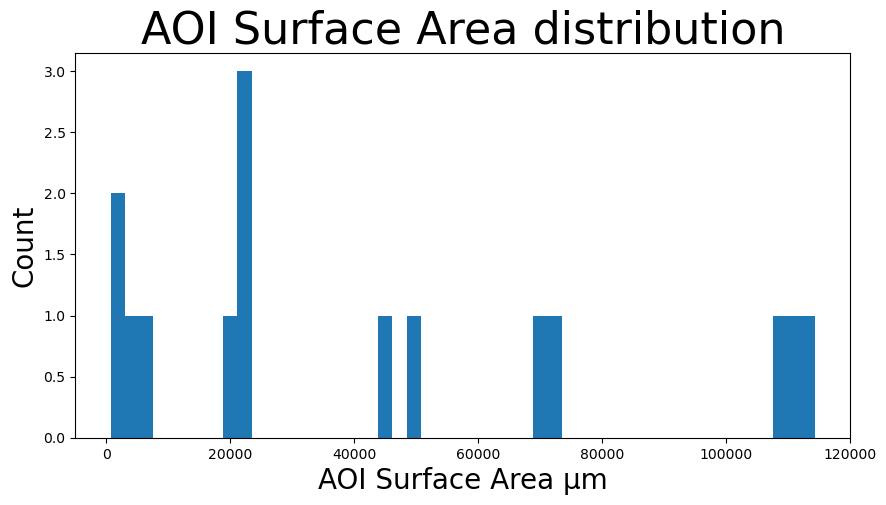

In [29]:
# ToDo: Add colouring for different AOI types
SAHist = plot_SA_Hist(surfArea)


## <span style="color:green"> Plot Binding Density histograms (in plate order) </sapan>
<div class="alert alert-block alert-success">
Binding density is calculated per lane on the nCounter cartridge. This is equivalent to the columns on hte hybridisation plate. The binding density should be similar, but does not need to be exactly the same.
</div>


Number of unique combinations: 15


/home/pw17xq0/Documents/GitHub/DSP_EDA_Protein/functions/plotting.py:220: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sampleInfoExternal.columns, rotation='vertical')


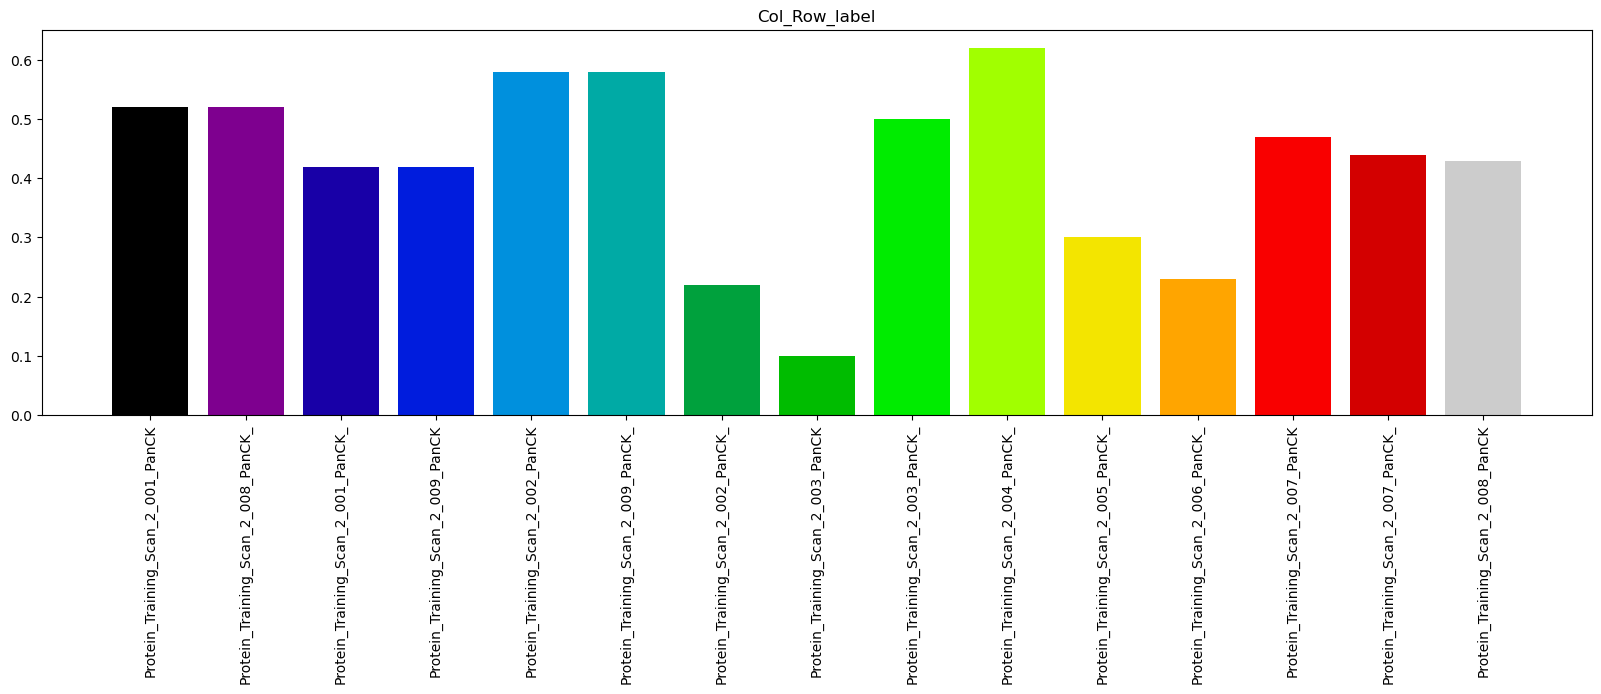


Number of unique combinations: 12


/home/pw17xq0/Documents/GitHub/DSP_EDA_Protein/functions/plotting.py:220: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sampleInfoExternal.columns, rotation='vertical')


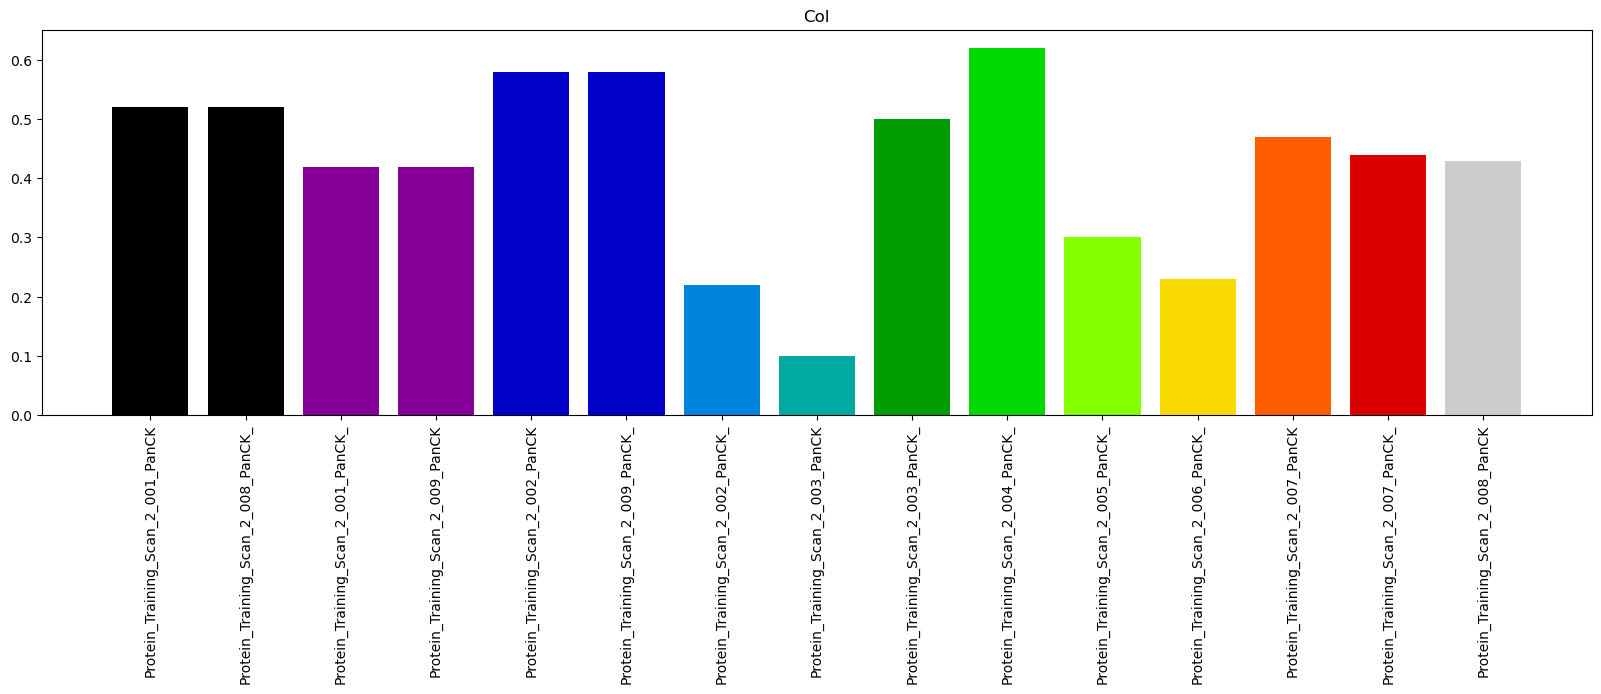


Number of unique combinations: 2


/home/pw17xq0/Documents/GitHub/DSP_EDA_Protein/functions/plotting.py:220: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sampleInfoExternal.columns, rotation='vertical')


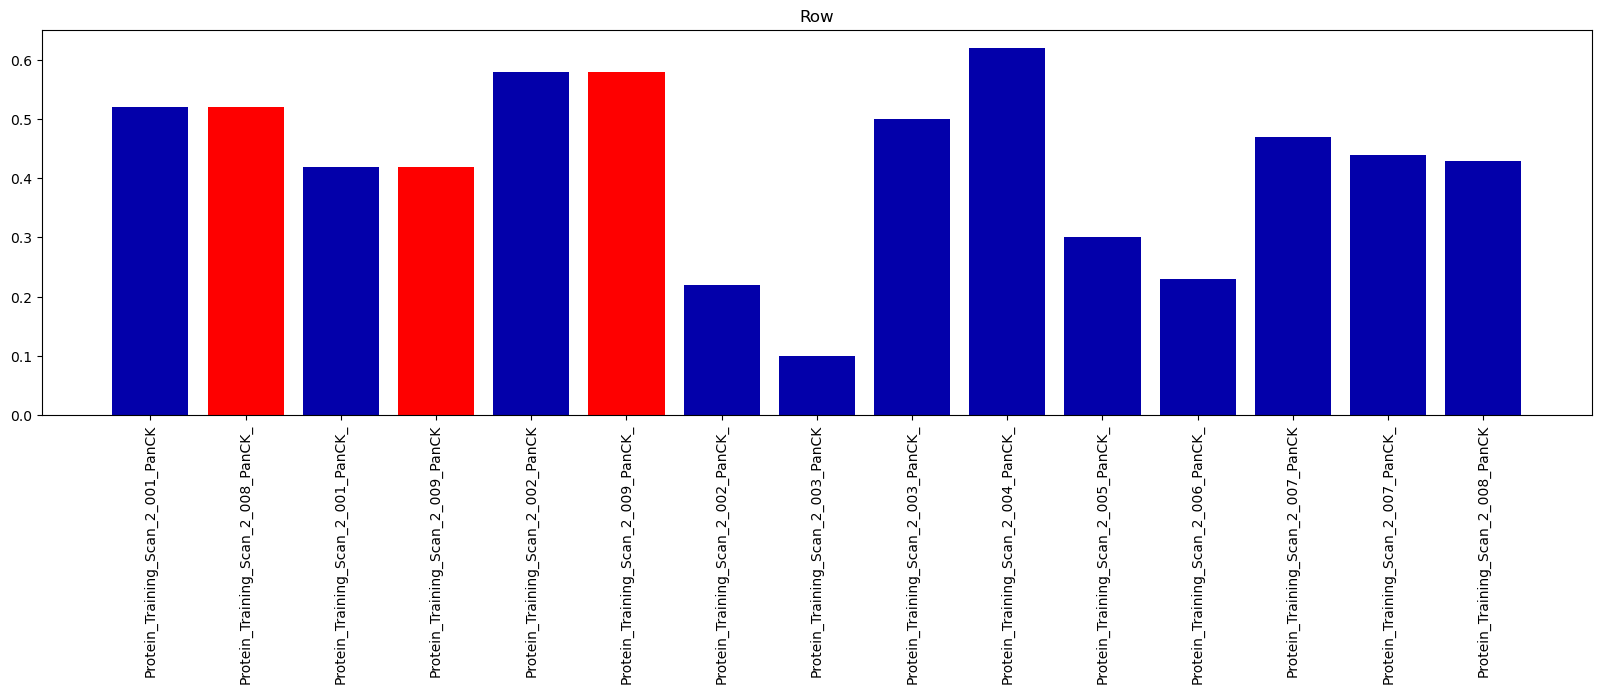


Number of unique combinations: 2


/home/pw17xq0/Documents/GitHub/DSP_EDA_Protein/functions/plotting.py:220: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sampleInfoExternal.columns, rotation='vertical')


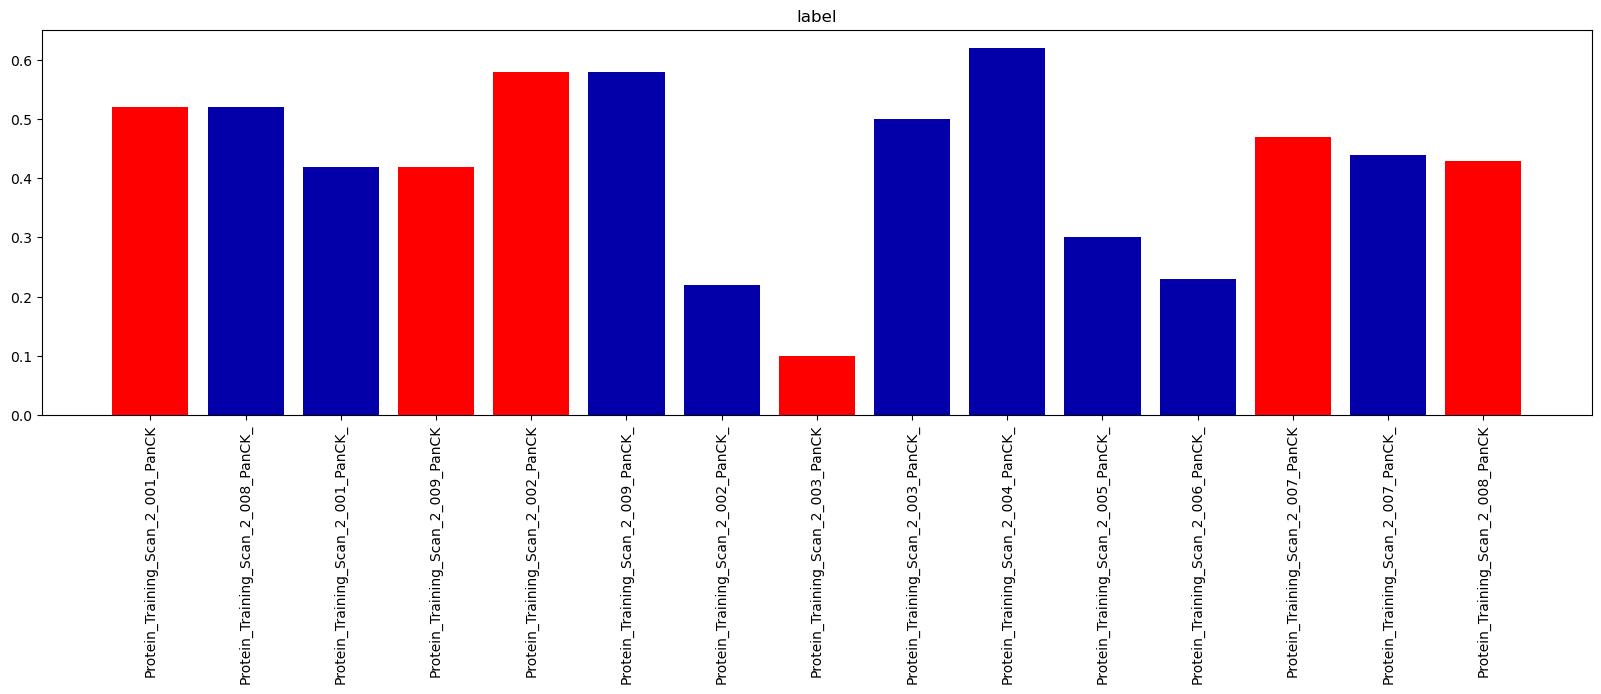

In [30]:
# generate binding density plots

binding_density_plot(sampleInfo, selectedInfo, configDict['selectedData'])
# binding_density_plot(sampleInfo, selectedInfo, 'Col')

for s in selectedFactors:
    binding_density_plot(sampleInfo, selectedInfo, s)
    

## <span style="color:green"> Visualise raw probe values before any normalisation </sapan>
<div class="alert alert-block alert-success">
Checking the raw probe values can help identify any systemic issues that may be present in the data set.
</div>

<div class="alert alert-block alert-danger">
The plots below are aranged with the individual probes on the x axis and probe count on the y axis. each sample is represented by a dot for the probe value for each probe.
</div>

In [31]:
# Show the selected data rows that are currently selected
print('configDict[\'selectedData\'] :\t' + str(configDict['selectedData']))

configDict['selectedData'] :	['Col', 'Row', 'label']


In [32]:
# Show some of the log transformed data to be plotted
dataLog1External

,Protein_Training_Scan_2_001_PanCK,Protein_Training_Scan_2_001_PanCK_,Protein_Training_Scan_2_002_PanCK,Protein_Training_Scan_2_002_PanCK_,Protein_Training_Scan_2_003_PanCK,Protein_Training_Scan_2_003_PanCK_,Protein_Training_Scan_2_004_PanCK_,Protein_Training_Scan_2_005_PanCK_,Protein_Training_Scan_2_006_PanCK_,Protein_Training_Scan_2_007_PanCK,Protein_Training_Scan_2_007_PanCK_,Protein_Training_Scan_2_008_PanCK,Protein_Training_Scan_2_008_PanCK_,Protein_Training_Scan_2_009_PanCK,Protein_Training_Scan_2_009_PanCK_,mean,probeClass
CD45,9.538421,0.000000,6.594051,9.703328,0.00000,7.781399,14.021106,13.420717,11.669411,14.718407,14.930436,13.881854,14.806466,14.728152,15.771491,10.771015,E
PD-L1,5.259650,0.000000,2.101671,5.452753,0.00000,3.117940,7.003299,6.261482,4.936805,9.524007,7.490800,7.664718,7.541895,9.331682,8.191154,5.591857,E
Ms IgG2a,5.723379,3.469720,3.726662,6.055536,0.00000,3.944688,7.717631,6.895606,5.663166,7.953782,7.604779,7.121248,7.832744,7.940732,8.377669,6.001823,B
Ki-67,15.621782,0.999036,12.098735,15.806660,0.00000,13.832543,17.344110,16.715321,15.006763,11.973921,11.599380,11.686760,12.662104,11.770662,11.983387,11.940077,E
Beta-2-microglobulin,8.635979,0.948096,5.254481,9.002978,0.00000,6.837662,10.730366,9.618899,8.229985,11.592559,11.260073,10.504428,11.086535,11.451706,11.991821,8.476371,E
HYB-POS,11.643421,0.000000,11.587450,13.098969,1.09605,12.650872,11.819950,13.164969,13.094848,11.898147,10.945889,13.048716,11.380805,12.751063,11.440655,10.641454,A
CD4,8.629571,0.000000,4.868810,8.814823,0.00000,6.716872,12.832787,11.979573,10.470086,11.585185,11.415573,10.687910,11.162433,11.888409,12.906134,8.930544,E
PD-1,7.565395,1.556997,4.047822,7.803522,0.00000,5.713525,9.409118,8.527814,7.118016,9.533441,9.421431,8.888670,9.435675,9.297349,9.921095,7.215991,E
GZMB,9.291324,1.055586,6.355654,9.614777,0.00000,7.430381,11.053037,10.666504,8.763485,10.646257,10.622766,9.957619,10.663409,10.507158,11.205970,8.522261,E
SMA,10.806207,0.000000,7.693563,10.978963,0.00000,8.432075,10.742170,9.853822,8.372408,12.644332,12.889141,11.613396,12.575315,12.931310,14.359041,9.592783,E



Number of unique combinations: 12

Number of unique combinations: 2

Number of unique combinations: 2


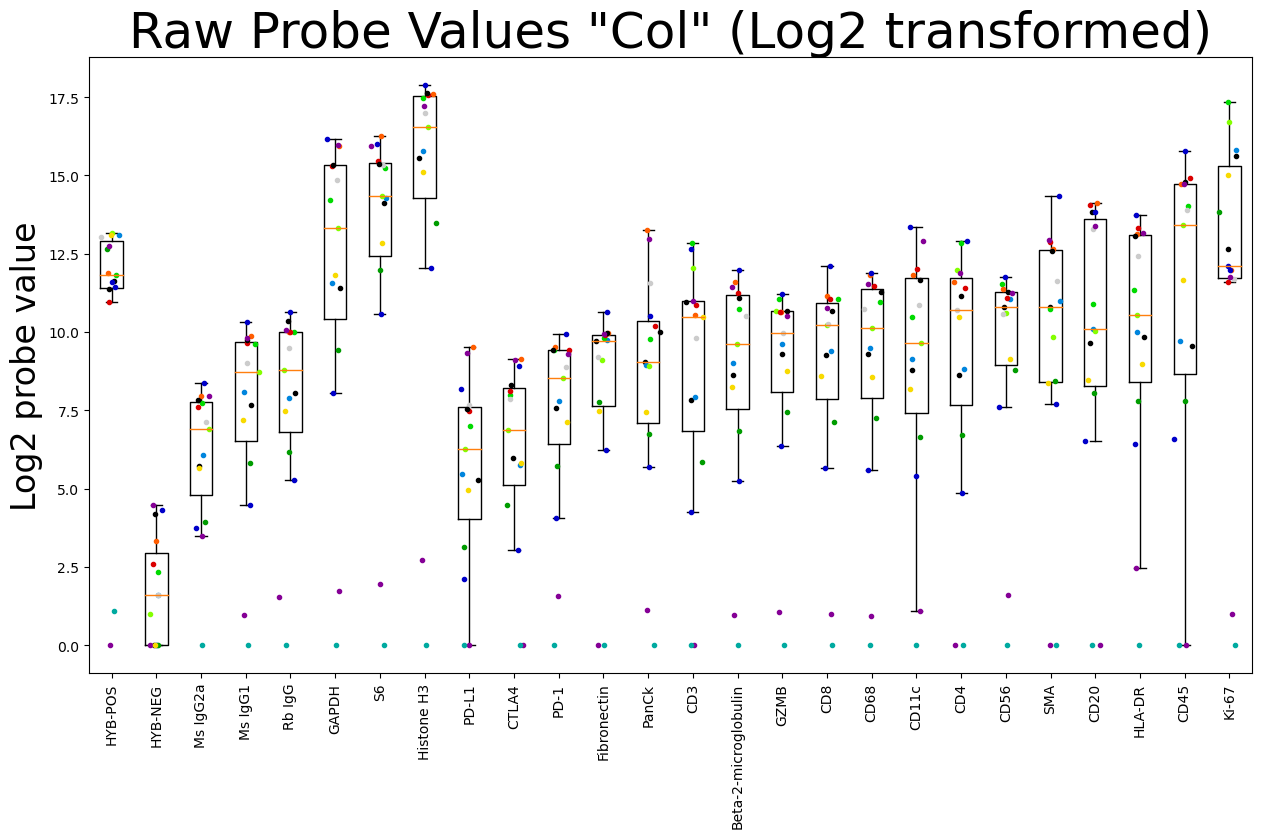

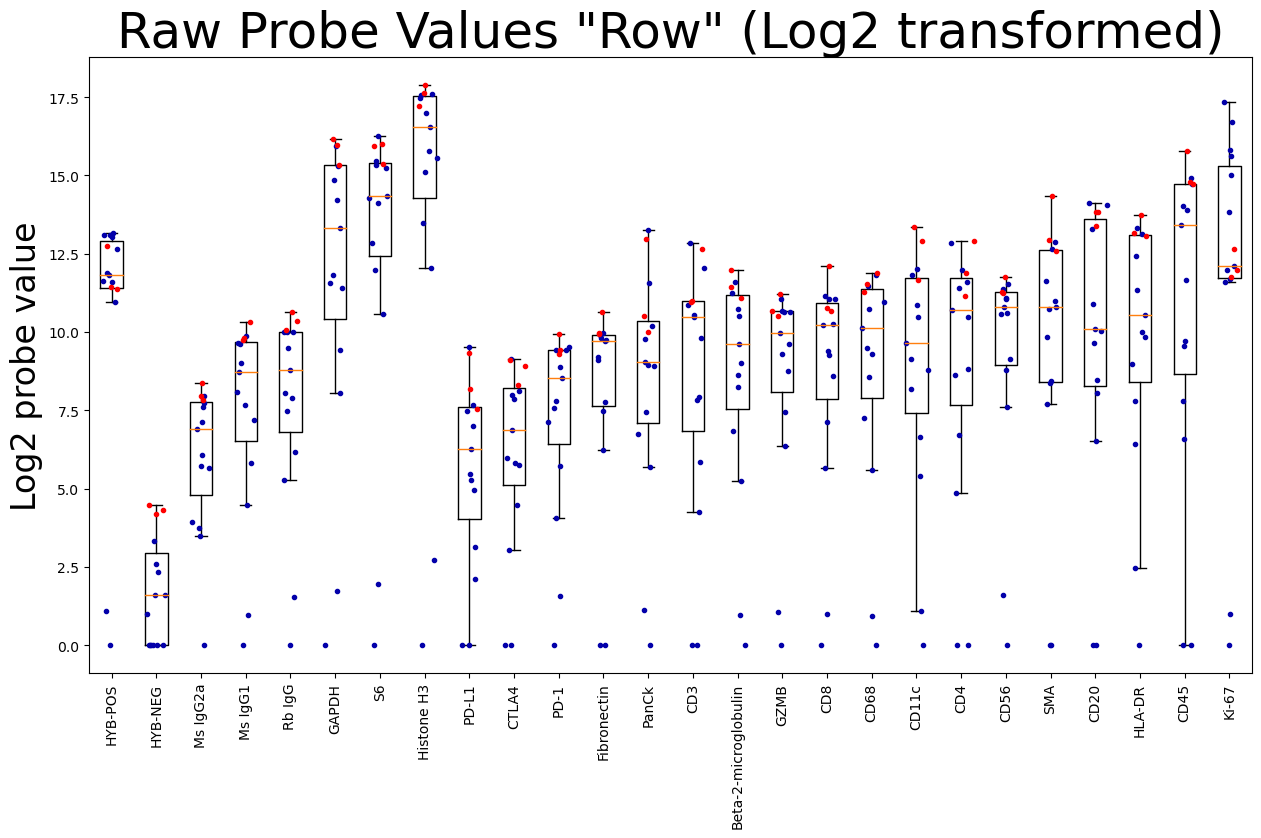

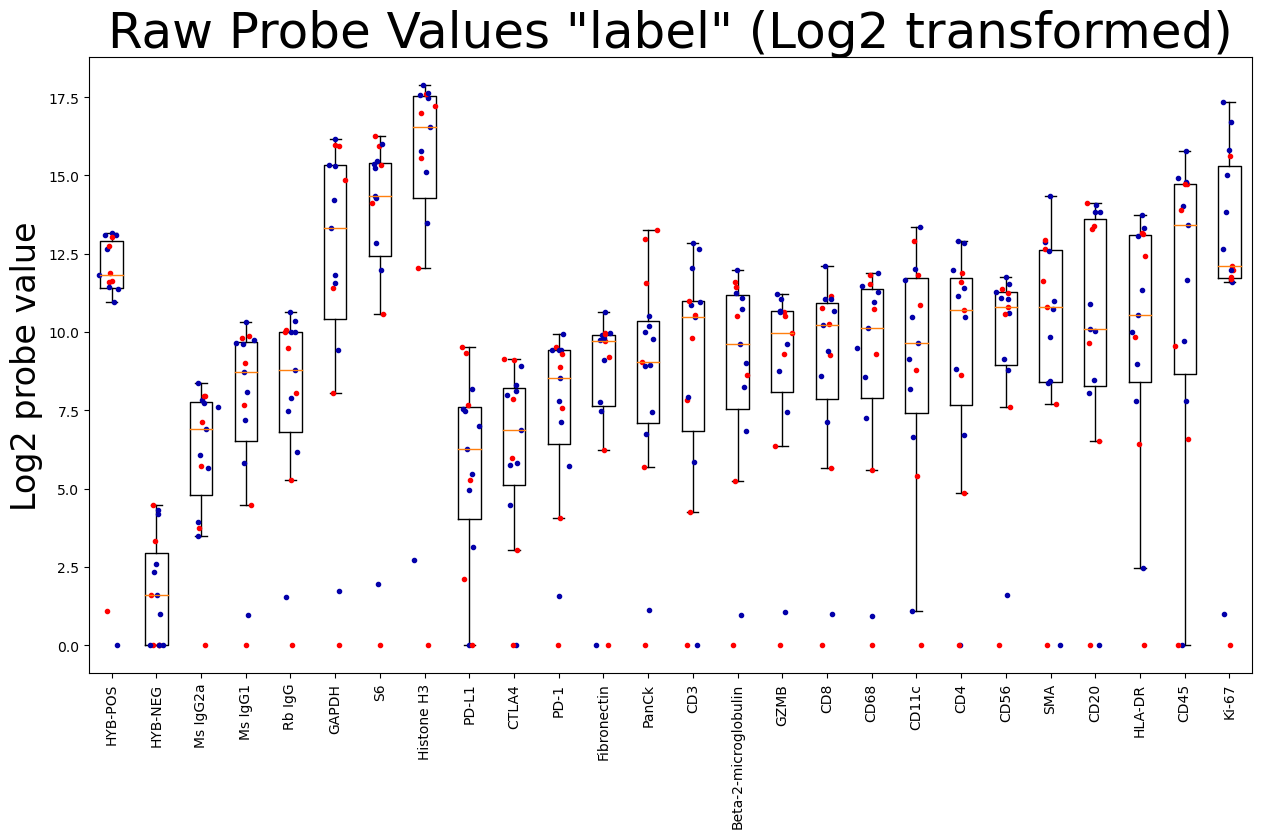

In [33]:
dataSortedRaw = dataLog1External.sort_values(by = ['probeClass', 'mean'], ascending=[True,True])

# for s in configDict['selectedData']:
for s in selectedFactors:
    draw_probe_plot(dataSortedRaw, sampleInfo, selectedInfo, s, 'Raw Probe Values \"' + s + '\"', savefig=os.path.join(os.getcwd(),'probe_Plot.svg'))
    


In [34]:
dataLog1External

,Protein_Training_Scan_2_001_PanCK,Protein_Training_Scan_2_001_PanCK_,Protein_Training_Scan_2_002_PanCK,Protein_Training_Scan_2_002_PanCK_,Protein_Training_Scan_2_003_PanCK,Protein_Training_Scan_2_003_PanCK_,Protein_Training_Scan_2_004_PanCK_,Protein_Training_Scan_2_005_PanCK_,Protein_Training_Scan_2_006_PanCK_,Protein_Training_Scan_2_007_PanCK,Protein_Training_Scan_2_007_PanCK_,Protein_Training_Scan_2_008_PanCK,Protein_Training_Scan_2_008_PanCK_,Protein_Training_Scan_2_009_PanCK,Protein_Training_Scan_2_009_PanCK_,mean,probeClass
CD45,9.538421,0.000000,6.594051,9.703328,0.00000,7.781399,14.021106,13.420717,11.669411,14.718407,14.930436,13.881854,14.806466,14.728152,15.771491,10.771015,E
PD-L1,5.259650,0.000000,2.101671,5.452753,0.00000,3.117940,7.003299,6.261482,4.936805,9.524007,7.490800,7.664718,7.541895,9.331682,8.191154,5.591857,E
Ms IgG2a,5.723379,3.469720,3.726662,6.055536,0.00000,3.944688,7.717631,6.895606,5.663166,7.953782,7.604779,7.121248,7.832744,7.940732,8.377669,6.001823,B
Ki-67,15.621782,0.999036,12.098735,15.806660,0.00000,13.832543,17.344110,16.715321,15.006763,11.973921,11.599380,11.686760,12.662104,11.770662,11.983387,11.940077,E
Beta-2-microglobulin,8.635979,0.948096,5.254481,9.002978,0.00000,6.837662,10.730366,9.618899,8.229985,11.592559,11.260073,10.504428,11.086535,11.451706,11.991821,8.476371,E
HYB-POS,11.643421,0.000000,11.587450,13.098969,1.09605,12.650872,11.819950,13.164969,13.094848,11.898147,10.945889,13.048716,11.380805,12.751063,11.440655,10.641454,A
CD4,8.629571,0.000000,4.868810,8.814823,0.00000,6.716872,12.832787,11.979573,10.470086,11.585185,11.415573,10.687910,11.162433,11.888409,12.906134,8.930544,E
PD-1,7.565395,1.556997,4.047822,7.803522,0.00000,5.713525,9.409118,8.527814,7.118016,9.533441,9.421431,8.888670,9.435675,9.297349,9.921095,7.215991,E
GZMB,9.291324,1.055586,6.355654,9.614777,0.00000,7.430381,11.053037,10.666504,8.763485,10.646257,10.622766,9.957619,10.663409,10.507158,11.205970,8.522261,E
SMA,10.806207,0.000000,7.693563,10.978963,0.00000,8.432075,10.742170,9.853822,8.372408,12.644332,12.889141,11.613396,12.575315,12.931310,14.359041,9.592783,E


In [35]:
sampleInfo

,Protein_Training_Scan_2_001_PanCK,Protein_Training_Scan_2_008_PanCK_,Protein_Training_Scan_2_001_PanCK_,Protein_Training_Scan_2_009_PanCK,Protein_Training_Scan_2_002_PanCK,Protein_Training_Scan_2_009_PanCK_,Protein_Training_Scan_2_002_PanCK_,Protein_Training_Scan_2_003_PanCK,Protein_Training_Scan_2_003_PanCK_,Protein_Training_Scan_2_004_PanCK_,Protein_Training_Scan_2_005_PanCK_,Protein_Training_Scan_2_006_PanCK_,Protein_Training_Scan_2_007_PanCK,Protein_Training_Scan_2_007_PanCK_,Protein_Training_Scan_2_008_PanCK
Custom Segment Name,Protein Training Scan 2 | 001 | PanCK,Protein Training Scan 2 | 008 | PanCK-,Protein Training Scan 2 | 001 | PanCK-,Protein Training Scan 2 | 009 | PanCK,Protein Training Scan 2 | 002 | PanCK,Protein Training Scan 2 | 009 | PanCK-,Protein Training Scan 2 | 002 | PanCK-,Protein Training Scan 2 | 003 | PanCK,Protein Training Scan 2 | 003 | PanCK-,Protein Training Scan 2 | 004 | PanCK-,Protein Training Scan 2 | 005 | PanCK-,Protein Training Scan 2 | 006 | PanCK-,Protein Training Scan 2 | 007 | PanCK,Protein Training Scan 2 | 007 | PanCK-,Protein Training Scan 2 | 008 | PanCK
ROI,70ecd5ab-237e-4ffc-a551-8cc884a9b43d,69012c7d-e2d3-4270-9304-dded4c0fccb9,70ecd5ab-237e-4ffc-a551-8cc884a9b43d,2b4064cd-ecf9-4e94-a2c1-b6adeeafbe2d,35fef07e-3469-4820-b8c8-e27e09d4b656,2b4064cd-ecf9-4e94-a2c1-b6adeeafbe2d,35fef07e-3469-4820-b8c8-e27e09d4b656,002b093a-c718-4ff2-8cd1-60716b50f8d3,002b093a-c718-4ff2-8cd1-60716b50f8d3,69b1234e-c06b-4d52-bdf9-d132963489dd,ad35f44f-121e-4c0b-88b5-78a277eb7ec4,c67af754-f757-4e78-80c1-f805a4904c68,c2887db3-4e02-4782-95b2-e35d0bb939c9,c2887db3-4e02-4782-95b2-e35d0bb939c9,69012c7d-e2d3-4270-9304-dded4c0fccb9
ROI (Label),001,008,001,009,002,009,002,003,003,004,005,006,007,007,008
Segment,fa666fdc-94af-44b4-9c79-d7b6c7f6b213,81d4cc78-b47e-47aa-93a9-edbfebbf8502,adfcc135-4d14-4580-9095-0fa69bc6328b,f5e7b20e-4aef-4fe5-9cc0-da016326cc80,fccd8264-8a42-4a3f-a270-baa302c0d49e,0bf37ec3-2c95-4811-86fe-1ad584c7b1ef,ccd2588a-1a0e-4f0c-aa73-5f444239f462,7c09abc5-b11c-4dc5-8253-1d85dc353ef9,943322d9-1924-4eeb-ad51-b25251018cdf,0da7f68b-9557-4346-b144-28526eaf9457,09907965-9ccb-4812-a901-698d7d7b085c,27b6dc61-8a93-4aa7-9e01-a3bb6703dc97,574abf4f-61a8-4ace-b1ee-2927dd8ead37,cc2f645b-f45b-4618-92af-2f546c88edc5,78b54b16-729e-4e76-8f1c-f6687f71d67e
Segment (Name/ Label),PanCK,PanCK-,PanCK-,PanCK,PanCK,PanCK-,PanCK-,PanCK,PanCK-,PanCK-,PanCK-,PanCK-,PanCK,PanCK-,PanCK
ROI X Coordinate,17573.302734375,10950.580078125,17573.302734375,8858.3017578125,18044.623046875,8858.3017578125,18044.623046875,20909.033203125,20909.033203125,18334.525390625,21265.640625,18035.34375,10153.720703125,10153.720703125,10950.580078125
ROI Y Coordinate,3154.49243164062,29721.830078125,3154.49243164062,27368.12109375,4290.5947265625,27368.12109375,4290.5947265625,4725.6982421875,4725.6982421875,24665.21484375,25971.27734375,27307.181640625,28651.78125,28651.78125,29721.830078125
Segment Tags,PanCK,PanCK-,PanCK-,PanCK,PanCK,PanCK-,PanCK-,PanCK,PanCK-,PanCK-,PanCK-,PanCK-,PanCK,PanCK-,PanCK
AOI,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
AOI surface area,21891,71728,50650,44538,1762,111708,21831,696,5004,107663,22538,6762,70509,114406,20199


Text(0, 0.5, 'HYB-POS (Log2 transformed)')

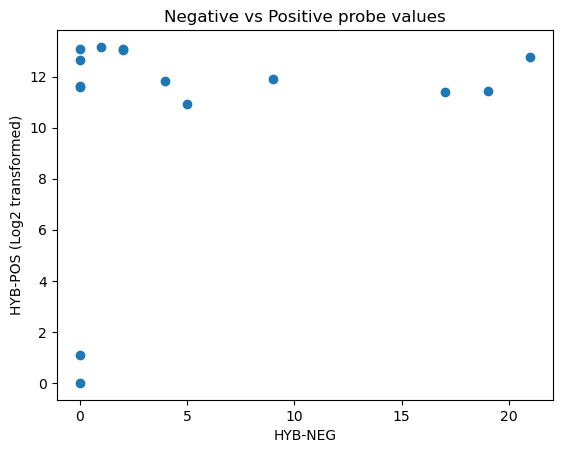

In [36]:
# ToDo: Add cmap for a single factor

# Plot of non-log transformed HYB-NEG values vs log transformed HYB-POS values
plt.scatter(np.exp2(dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['HYB-NEG'])-1,
            dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['HYB-POS'])
plt.title('Negative vs Positive probe values')
plt.xlabel('HYB-NEG')
plt.ylabel('HYB-POS (Log2 transformed)')

Text(0, 0.5, 'AOI Surface Area')

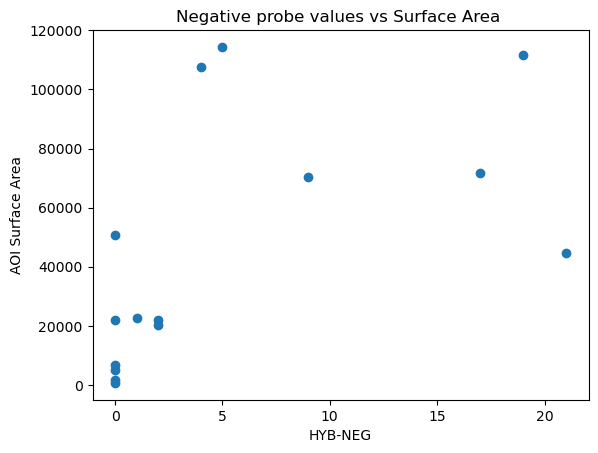

In [37]:
# ToDo: Add cmap for a single factor

# Plot of non-log transformed HYB-NEG values vs AOI surface area values
plt.scatter(np.exp2(dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['HYB-NEG'])-1,
        surfArea.reindex(dataLog1External.drop(labels=['mean','probeClass'],axis=1).columns))
plt.title('Negative probe values vs Surface Area ')
plt.xlabel('HYB-NEG')
plt.ylabel('AOI Surface Area')

## <span style="color:red"> Raw probe QC questions / checks: </sapan>

<div class="alert alert-block alert-danger">
Info on important questions to consider from QC steps
</div>

# <span style="color:orange"> Determine thresholding value for limit of detection for assay </span>

<div class="alert alert-block alert-warning">
In the following section a threshold can be set for primary interrogation of the assay limit of detection and probes and samples that may be usable for further analysis.<br><br>

After running through the following cells and deciding a threshold to use for this study, this threshold can be added to the config file for be automaticcaly imported for future runs.<br><br>

The threshold shoud be set as the first local minimum closest to the start of the 'real' values.


Flesh this documentation out more !!!

</div>

In [38]:
# ToDo: Add plots where hyb-neg and negative controls are shown with separate cmaps

In [39]:
# Try to read in probeThreshold from config file.

try:
    probeThresholdIdx = configDict['probeThresholdIdx']
    probeThresholdSet = True
    print('Previous probe threshold was found')
except KeyError:
    probeThresholdSet = False
    print('No probe threshold was found')


Previous probe threshold was found


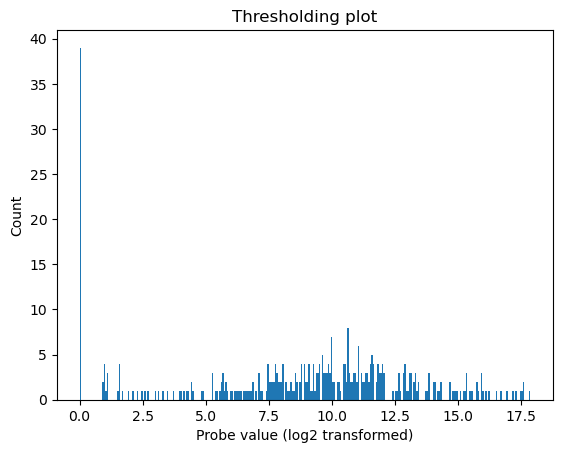

In [40]:
thresholding = ThresholdProbes(dataLog1External, 300)

In [41]:
#Set index value to use for minimum expression threshold from thresholding.

if not(probeThresholdSet):
    probeThresholdIdx = 38 # Threshold can be set here if it was not read into the configDict

thresholding.set_threshold_idx(probeThresholdIdx)

Threshold index :	32
Threshold count :	1
Threshold point :	 1.908


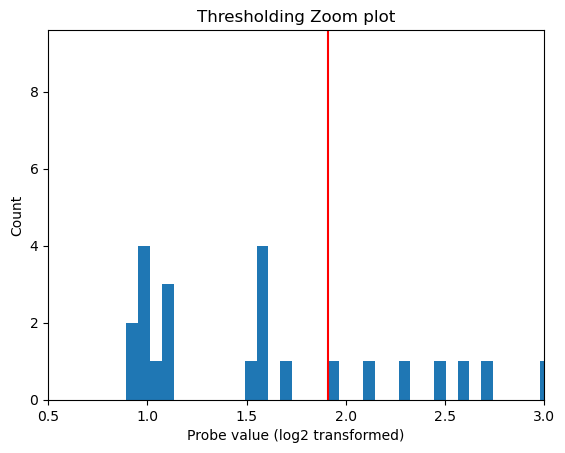

In [42]:
thresholding.zoom_plot(0.5,3)

In [43]:
thresholding.check_threshold(0,50)
thresholding.check_threshold(25,40)

Histogram[0] range :	[39.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  4.  1.
  3.  0.  0.  0.  0.  0.  0.  1.  4.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.]
Histogram[1] range :	[0.         0.0596295  0.11925901 0.17888851 0.23851801 0.29814753
 0.35777703 0.41740653 0.47703603 0.53666556 0.59629506 0.65592456
 0.71555406 0.77518356 0.83481306 0.89444256 0.95407206 1.01370156
 1.07333112 1.13296056 1.19259012 1.25221956 1.31184912 1.37147856
 1.43110812 1.49073756 1.55036712 1.60999656 1.66962612 1.72925556
 1.78888512 1.84851468 1.90814412 1.96777368 2.02740312 2.08703256
 2.14666224 2.20629168 2.26592112 2.32555056 2.38518023 2.44480968
 2.50443912 2.56406856 2.62369823 2.68332767 2.74295712 2.80258679
 2.86221623 2.92184567]
Histogram[0] range :	[1. 4. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
Histogram[1] range :	[1.49073756 1.55036712 1.60999656 1.66962612 1.72925556 1.78888512
 1.84851468 1.90814412 1.96777368 2.02

In [44]:
thresholding.check_threshold(32,33)


Histogram[0] range :	[1.]
Histogram[1] range :	[1.90814412]


In [45]:
probeThresholdIdx

32

In [46]:
print(f'threshold Index :\t%d'%(probeThresholdIdx))
print(f'threshold point :\t%6.3f'%(thresholding.threshold))
ETFiltered = thresholding.get_filter()

threshold Index :	32
threshold point :	 1.908


In [47]:
if not(probeThresholdSet):
    with open('config.txt', 'a') as f:
        f.write('probeThresholdIdx : ')
        f.write(str(probeThresholdIdx))
        f.write('\n')

## <span style="color:green"> Identify outlier AOIs and probes </sapan>
<div class="alert alert-block alert-success">
    text here 
</div>


## <span style="color:green"> Plot counts of AOIs and probes passing thresholds </sapan>
<div class="alert alert-block alert-success">
text here<br><br>

describe fail AOI and fail probe files
</div>

In [48]:
exportPath = dataPath[:dataPath.rfind('/')]

thisMin :	0
thisMax :	26


(-2.0, 28.0)

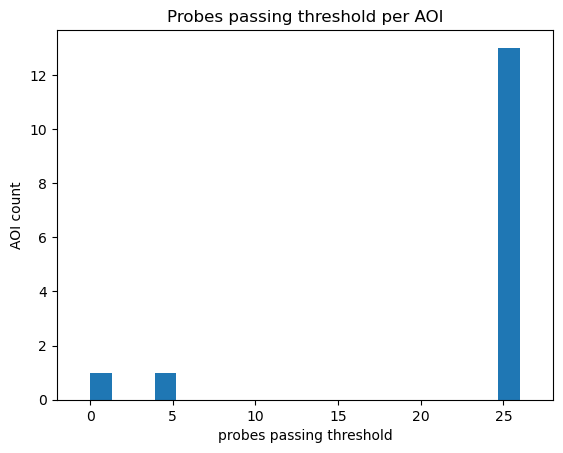

In [49]:
# get counts of how many probes are above the expression threshold for each AOI
passAOI = ETFiltered.sum()
thisMin = min(passAOI)
thisMax = max(passAOI)
print(f'thisMin :\t{thisMin}')
print(f'thisMax :\t{thisMax}')

plt.title('Probes passing threshold per AOI')
plt.xlabel('probes passing threshold')
plt.ylabel('AOI count')
plt.hist(passAOI.values, bins=20)
plt.xlim(thisMin-2,thisMax+2)
# plt.semilogy()

In [50]:
passAOI.sort_values().index[:5]

Index(['Protein_Training_Scan_2_003_PanCK',
       'Protein_Training_Scan_2_001_PanCK_',
       'Protein_Training_Scan_2_001_PanCK',
       'Protein_Training_Scan_2_002_PanCK',
       'Protein_Training_Scan_2_002_PanCK_'],
      dtype='object')

In [51]:
failAOIs = passAOI[passAOI < 35]
failAOIs.index

Index(['Protein_Training_Scan_2_001_PanCK',
       'Protein_Training_Scan_2_001_PanCK_',
       'Protein_Training_Scan_2_002_PanCK',
       'Protein_Training_Scan_2_002_PanCK_',
       'Protein_Training_Scan_2_003_PanCK',
       'Protein_Training_Scan_2_003_PanCK_',
       'Protein_Training_Scan_2_004_PanCK_',
       'Protein_Training_Scan_2_005_PanCK_',
       'Protein_Training_Scan_2_006_PanCK_',
       'Protein_Training_Scan_2_007_PanCK',
       'Protein_Training_Scan_2_007_PanCK_',
       'Protein_Training_Scan_2_008_PanCK',
       'Protein_Training_Scan_2_008_PanCK_',
       'Protein_Training_Scan_2_009_PanCK',
       'Protein_Training_Scan_2_009_PanCK_'],
      dtype='object')

In [52]:
sampleInfo[failAOIs.index]

,Protein_Training_Scan_2_001_PanCK,Protein_Training_Scan_2_001_PanCK_,Protein_Training_Scan_2_002_PanCK,Protein_Training_Scan_2_002_PanCK_,Protein_Training_Scan_2_003_PanCK,Protein_Training_Scan_2_003_PanCK_,Protein_Training_Scan_2_004_PanCK_,Protein_Training_Scan_2_005_PanCK_,Protein_Training_Scan_2_006_PanCK_,Protein_Training_Scan_2_007_PanCK,Protein_Training_Scan_2_007_PanCK_,Protein_Training_Scan_2_008_PanCK,Protein_Training_Scan_2_008_PanCK_,Protein_Training_Scan_2_009_PanCK,Protein_Training_Scan_2_009_PanCK_
Custom Segment Name,Protein Training Scan 2 | 001 | PanCK,Protein Training Scan 2 | 001 | PanCK-,Protein Training Scan 2 | 002 | PanCK,Protein Training Scan 2 | 002 | PanCK-,Protein Training Scan 2 | 003 | PanCK,Protein Training Scan 2 | 003 | PanCK-,Protein Training Scan 2 | 004 | PanCK-,Protein Training Scan 2 | 005 | PanCK-,Protein Training Scan 2 | 006 | PanCK-,Protein Training Scan 2 | 007 | PanCK,Protein Training Scan 2 | 007 | PanCK-,Protein Training Scan 2 | 008 | PanCK,Protein Training Scan 2 | 008 | PanCK-,Protein Training Scan 2 | 009 | PanCK,Protein Training Scan 2 | 009 | PanCK-
ROI,70ecd5ab-237e-4ffc-a551-8cc884a9b43d,70ecd5ab-237e-4ffc-a551-8cc884a9b43d,35fef07e-3469-4820-b8c8-e27e09d4b656,35fef07e-3469-4820-b8c8-e27e09d4b656,002b093a-c718-4ff2-8cd1-60716b50f8d3,002b093a-c718-4ff2-8cd1-60716b50f8d3,69b1234e-c06b-4d52-bdf9-d132963489dd,ad35f44f-121e-4c0b-88b5-78a277eb7ec4,c67af754-f757-4e78-80c1-f805a4904c68,c2887db3-4e02-4782-95b2-e35d0bb939c9,c2887db3-4e02-4782-95b2-e35d0bb939c9,69012c7d-e2d3-4270-9304-dded4c0fccb9,69012c7d-e2d3-4270-9304-dded4c0fccb9,2b4064cd-ecf9-4e94-a2c1-b6adeeafbe2d,2b4064cd-ecf9-4e94-a2c1-b6adeeafbe2d
ROI (Label),001,001,002,002,003,003,004,005,006,007,007,008,008,009,009
Segment,fa666fdc-94af-44b4-9c79-d7b6c7f6b213,adfcc135-4d14-4580-9095-0fa69bc6328b,fccd8264-8a42-4a3f-a270-baa302c0d49e,ccd2588a-1a0e-4f0c-aa73-5f444239f462,7c09abc5-b11c-4dc5-8253-1d85dc353ef9,943322d9-1924-4eeb-ad51-b25251018cdf,0da7f68b-9557-4346-b144-28526eaf9457,09907965-9ccb-4812-a901-698d7d7b085c,27b6dc61-8a93-4aa7-9e01-a3bb6703dc97,574abf4f-61a8-4ace-b1ee-2927dd8ead37,cc2f645b-f45b-4618-92af-2f546c88edc5,78b54b16-729e-4e76-8f1c-f6687f71d67e,81d4cc78-b47e-47aa-93a9-edbfebbf8502,f5e7b20e-4aef-4fe5-9cc0-da016326cc80,0bf37ec3-2c95-4811-86fe-1ad584c7b1ef
Segment (Name/ Label),PanCK,PanCK-,PanCK,PanCK-,PanCK,PanCK-,PanCK-,PanCK-,PanCK-,PanCK,PanCK-,PanCK,PanCK-,PanCK,PanCK-
ROI X Coordinate,17573.302734375,17573.302734375,18044.623046875,18044.623046875,20909.033203125,20909.033203125,18334.525390625,21265.640625,18035.34375,10153.720703125,10153.720703125,10950.580078125,10950.580078125,8858.3017578125,8858.3017578125
ROI Y Coordinate,3154.49243164062,3154.49243164062,4290.5947265625,4290.5947265625,4725.6982421875,4725.6982421875,24665.21484375,25971.27734375,27307.181640625,28651.78125,28651.78125,29721.830078125,29721.830078125,27368.12109375,27368.12109375
Segment Tags,PanCK,PanCK-,PanCK,PanCK-,PanCK,PanCK-,PanCK-,PanCK-,PanCK-,PanCK,PanCK-,PanCK,PanCK-,PanCK,PanCK-
AOI,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
AOI surface area,21891,50650,1762,21831,696,5004,107663,22538,6762,70509,114406,20199,71728,44538,111708


In [53]:
# ToDo: Move this to config file
# writeOutput = True
if writeOutput:
    failAOIs.to_csv(os.path.join(exportPath,'failAOIs.csv'))
# writeOutput= False


(1.0, 19.0)

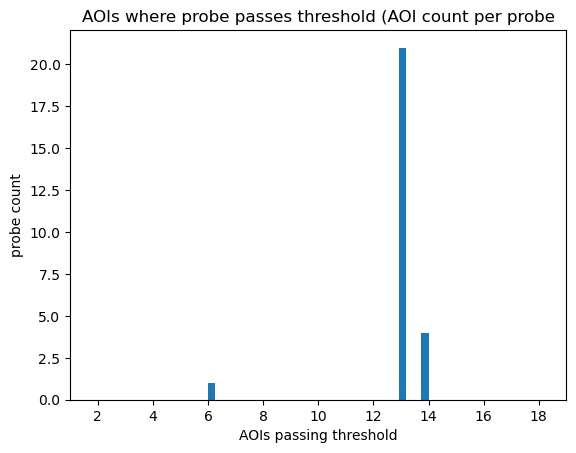

In [54]:
# plot how many AOIs are above the expression threshold for each probe

passProbe = ETFiltered.sum(axis=1)
thisMin = min(passProbe)
thisMax = max(passProbe)

plt.title('AOIs where probe passes threshold (AOI count per probe')
plt.xlabel('AOIs passing threshold')
plt.ylabel('probe count')
plt.hist(passProbe.values, bins=30)
plt.xlim(thisMin-5,thisMax+5)
# plt.semilogy()

In [55]:
# ToDo: Ask for a value to use for fail probes cutoff
# Use the group by factor function (need to finish and move to a method)

In [56]:
# ToDo: Sort this output
failProbes = passProbe[passProbe < 48]
failProbes

CD45                    13
PD-L1                   13
Ms IgG2a                14
Ki-67                   13
Beta-2-microglobulin    13
HYB-POS                 13
CD4                     13
PD-1                    13
GZMB                    13
SMA                     13
CD56                    13
Histone H3              14
CD8                     13
CTLA4                   13
CD68                    13
Ms IgG1                 13
CD11c                   13
PanCk                   13
HLA-DR                  14
Fibronectin             13
S6                      14
CD3                     13
Rb IgG                  13
GAPDH                   13
CD20                    13
HYB-NEG                  6
dtype: int64

In [57]:
failProbes = passProbe[passProbe < 100]
failProbes

CD45                    13
PD-L1                   13
Ms IgG2a                14
Ki-67                   13
Beta-2-microglobulin    13
HYB-POS                 13
CD4                     13
PD-1                    13
GZMB                    13
SMA                     13
CD56                    13
Histone H3              14
CD8                     13
CTLA4                   13
CD68                    13
Ms IgG1                 13
CD11c                   13
PanCk                   13
HLA-DR                  14
Fibronectin             13
S6                      14
CD3                     13
Rb IgG                  13
GAPDH                   13
CD20                    13
HYB-NEG                  6
dtype: int64

In [58]:
# ToDo: Move failProbes to config file ?

# writeOutput = True
if writeOutput:
    failProbes.to_csv(os.path.join(exportPath,'FailProbes.csv'))
# writeOutput= False


In [59]:
masterData.set_threshold(ETFiltered)

In [60]:
# masterData.threshold


# <span style="color:green"> ERCC corrected data </sapan>
<div class="alert alert-block alert-success">
    ERCC correction is the first essential step in data normalisation. This step accounts for differences in hybridisation efficiency and pipetting inaccuracies.
</div>

In [61]:
erccData = masterData.ERCC_norm()
erccData, _ = masterData.add_class_mean(erccData)


Positive Control count:	1, ['HYB-POS']
Nagative Control count:	4, ['Ms IgG2a', 'Ms IgG1', 'Rb IgG', 'HYB-NEG']
Ig Control count:	3, ['Ms IgG2a', 'Ms IgG1', 'Rb IgG']
HK Control count:	3, ['Histone H3', 'S6', 'GAPDH']
Endogenous probe count:	18, ['CD45', 'PD-L1', 'Ki-67', 'Beta-2-microglobulin', 'CD4', 'PD-1', 'GZMB', 'SMA', 'CD56', 'CD8', 'CTLA4', 'CD68', 'CD11c', 'PanCk', 'HLA-DR', 'Fibronectin', 'CD3', 'CD20']


In [62]:
erccData

,Protein_Training_Scan_2_001_PanCK,Protein_Training_Scan_2_001_PanCK_,Protein_Training_Scan_2_002_PanCK,Protein_Training_Scan_2_002_PanCK_,Protein_Training_Scan_2_003_PanCK,Protein_Training_Scan_2_003_PanCK_,Protein_Training_Scan_2_004_PanCK_,Protein_Training_Scan_2_005_PanCK_,Protein_Training_Scan_2_006_PanCK_,Protein_Training_Scan_2_007_PanCK,Protein_Training_Scan_2_007_PanCK_,Protein_Training_Scan_2_008_PanCK,Protein_Training_Scan_2_008_PanCK_,Protein_Training_Scan_2_009_PanCK,Protein_Training_Scan_2_009_PanCK_,mean,probeClass
CD45,8.536453,10.641454,5.648055,7.245813,9.545404,5.771981,12.842609,10.897202,9.216017,13.461714,14.626000,11.474592,14.067115,12.618543,14.972290,10.771016,E
PD-L1,4.257682,10.641454,1.155674,2.995238,9.545404,1.108521,5.824802,3.737966,2.483411,8.267314,7.186364,5.257456,6.802544,7.222073,7.391953,5.591857,E
Ms IgG2a,4.721412,14.111174,2.780666,3.598022,9.545404,1.935269,6.539135,4.372090,3.209772,6.697089,7.300343,4.713986,7.093393,5.831123,7.578468,6.001823,B
Ki-67,14.619815,11.640491,11.152739,13.349145,9.545404,11.823125,16.165615,14.191805,12.553370,10.717228,11.294944,9.279498,11.922752,9.661053,11.184186,11.940078,E
Beta-2-microglobulin,7.634011,11.589550,4.308485,6.545464,9.545404,4.828243,9.551869,7.095384,5.776591,10.335866,10.955637,8.097166,10.347183,9.342096,11.192620,8.476371,E
HYB-POS,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,A
CD4,7.627604,10.641454,3.922813,6.357308,9.545404,4.707454,11.654290,9.456058,8.016692,10.328492,11.111137,8.280648,10.423081,9.778799,12.106933,8.930544,E
PD-1,6.563427,12.198450,3.101826,5.346007,9.545404,3.704106,8.230621,6.004298,4.664622,8.276748,9.116995,6.481408,8.696323,7.187739,9.121894,7.215991,E
GZMB,8.289356,11.697041,5.409658,7.157262,9.545404,5.420963,9.874540,8.142988,6.310091,9.389565,10.318330,7.550357,9.924058,8.397549,10.406769,8.522262,E
SMA,9.804239,10.641454,6.747567,8.521448,9.545404,6.422656,9.563674,7.330306,5.919014,11.387639,12.584705,9.206134,11.835964,10.821700,13.559840,9.592784,E


# <span style="color:green"> Drop outlier AOIs and probes </sapan>
<div class="alert alert-block alert-success">
Some samples or probes may need to be dropped permanently. This can be done in the following steps.<br><br>


</div>

In [63]:
# ToDo: Add in options for interactively dropping samples.
# ToDo: read in AOIs and probes to be droped from csv files?


In [64]:
dropSamples = False
# dropSamples = True
dropSamplesTemp = []


In [65]:
# ToDo: Test this code with multiple projects

if dropSamples:
    if ('dropSamples' in configDict.keys()):
        dropSamples = configDict['dropSamples'].split(',')
        dropSamples = [x.strip() for x in dropSamples]
        dropSamples = [x.strip('\'') for x in dropSamples]
        dropSamples =pd.Index(dropSamples)



    print('dropping samples')
    erccData, sampleInfo = masterData.drop_AOIs(list(dropSamples), writeOrig=True)
    print(f'erccData.shape {erccData.shape}')
    erccData = masterData.ERCC_norm()
    erccData, sampleInfo = masterData.add_class_mean(masterData.ERCCData)

erccDataSorted = erccData.sort_values(by = ['probeClass', 'mean'], ascending=[True,True])



In [66]:
# # # ToDo: Tidy up handling of datasets within master data. There are too many copies at the moment!
# # # ERCC correction needs to be repeated after dropping AOIs

# if (type(dropSamples) == pd.core.indexes.base.Index):
#     print('dropping samples')
#     erccData, sampleInfo = masterData.drop_AOIs(list(dropSamples), writeOrig=True)
#     print(f'erccData.shape {erccData.shape}')
#     erccData = masterData.ERCC_norm()
#     erccData, sampleInfo = masterData.add_class_mean(masterData.ERCCData)

# erccDataSorted = erccData.sort_values(by = ['probeClass', 'mean'], ascending=[True,True])


In [67]:
if (not(type(dropSamples) == pd.core.indexes.base.Index) and (len(dropSamplesTemp) != 0)):
    print('writing drop samples to config file.')
    with open('config.txt', 'a') as config:
        config.write('dropSamples : ')
        config.write(', '.join([x for x in dropSamplesTemp]))
        config.write('\n')



# <span style="color:green"> Plot negative controls and housekeeping controls from raw data </sapan>
<div class="alert alert-block alert-success">
It's probably not neccessary to view the following, but lets just have a quick look at how the control values for the raw data is distributed to make sure there are no extreme outliers before ERCC normalisation.

</div>

In [68]:
# Calculate Ig control Geometric mean and Housekeeping gene Geometric mean
# Calculating the mean of log transformed data is analagous to calculating the geometric mean of the non-transformed data

HKGeoMean = dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc[masterData.HK].mean()
HKGeoMean = HKGeoMean.sort_values()

IgGeoMean = dataLog1External.drop(labels=['mean','probeClass'], axis=1).reindex(labels=HKGeoMean.index, axis=1).loc[masterData.IgCTLs].mean()

HKIgCtls = masterData.HK.copy()
HKIgCtls.extend(masterData.IgCTLs)

HKIgCtlGeoMeans = dataLog1External.drop(labels=['mean','probeClass'], axis=1).reindex(labels=HKGeoMean.index, axis=1).loc[HKIgCtls].mean()

HKIgCtls = masterData.HK.copy()
HKIgCtls.extend(masterData.IgCTLs)

print(f'masterData.HK :\t{masterData.HK}')
print(f'HKIgCtls :\t{HKIgCtls}')
print(f'HKGeoMean :\t{HKGeoMean}')


masterData.HK :	['Histone H3', 'S6', 'GAPDH']
HKIgCtls :	['Histone H3', 'S6', 'GAPDH', 'Ms IgG2a', 'Ms IgG1', 'Rb IgG']
HKGeoMean :	Protein_Training_Scan_2_003_PanCK      0.000000
Protein_Training_Scan_2_001_PanCK_     2.136055
Protein_Training_Scan_2_002_PanCK     10.223045
Protein_Training_Scan_2_003_PanCK_    11.632386
Protein_Training_Scan_2_006_PanCK_    13.261689
Protein_Training_Scan_2_001_PanCK     13.688483
Protein_Training_Scan_2_002_PanCK_    13.882352
Protein_Training_Scan_2_005_PanCK_    14.732829
Protein_Training_Scan_2_004_PanCK_    15.649554
Protein_Training_Scan_2_008_PanCK     15.726165
Protein_Training_Scan_2_007_PanCK_    16.110023
Protein_Training_Scan_2_008_PanCK_    16.114487
Protein_Training_Scan_2_009_PanCK     16.380938
Protein_Training_Scan_2_007_PanCK     16.608665
Protein_Training_Scan_2_009_PanCK_    16.680151
dtype: float32


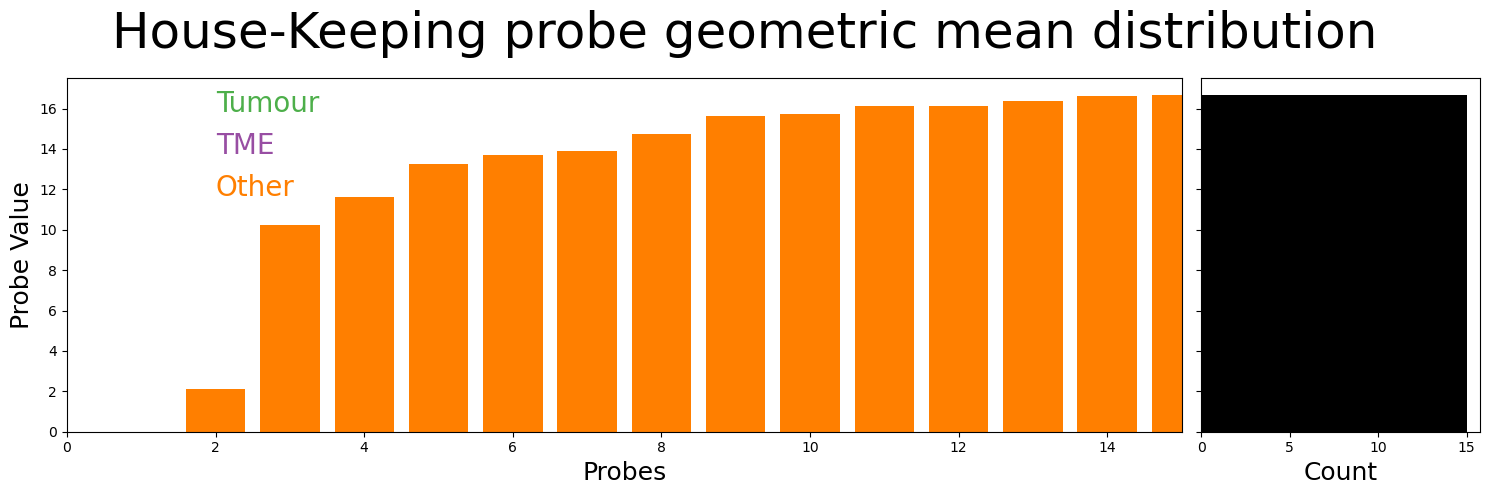

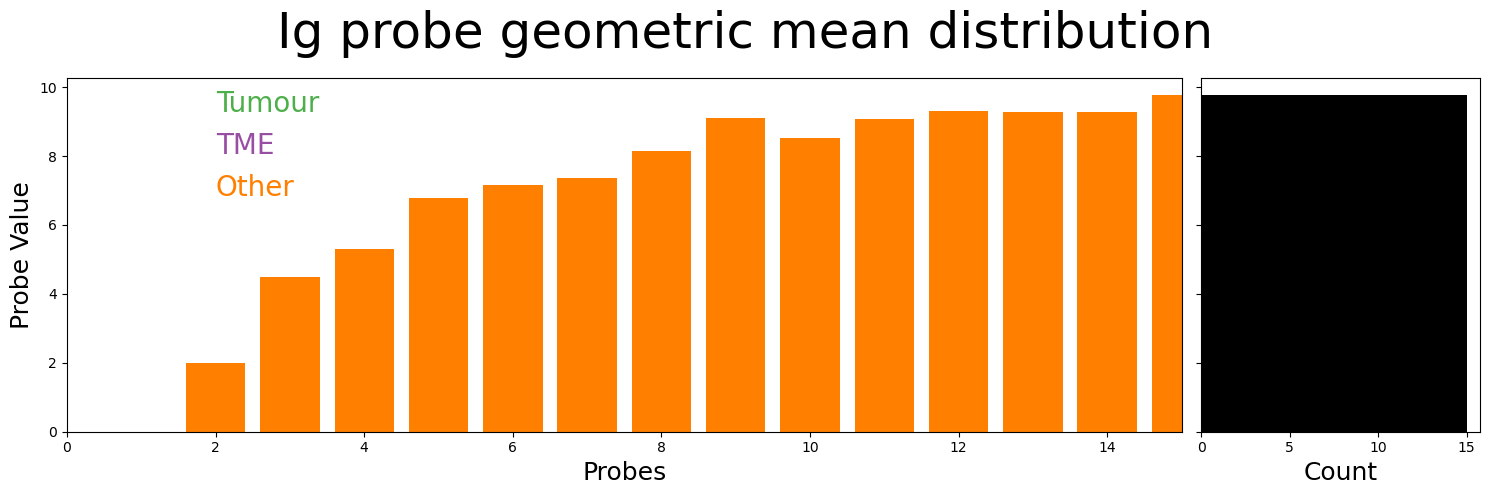

In [69]:
# ToDo: Fix up cmap for these plots. Choose a factor to colour by.

probe_GeoMean_Plots(HKGeoMean, 'House-Keeping probe geometric mean distribution')

probe_GeoMean_Plots(IgGeoMean, 'Ig probe geometric mean distribution')

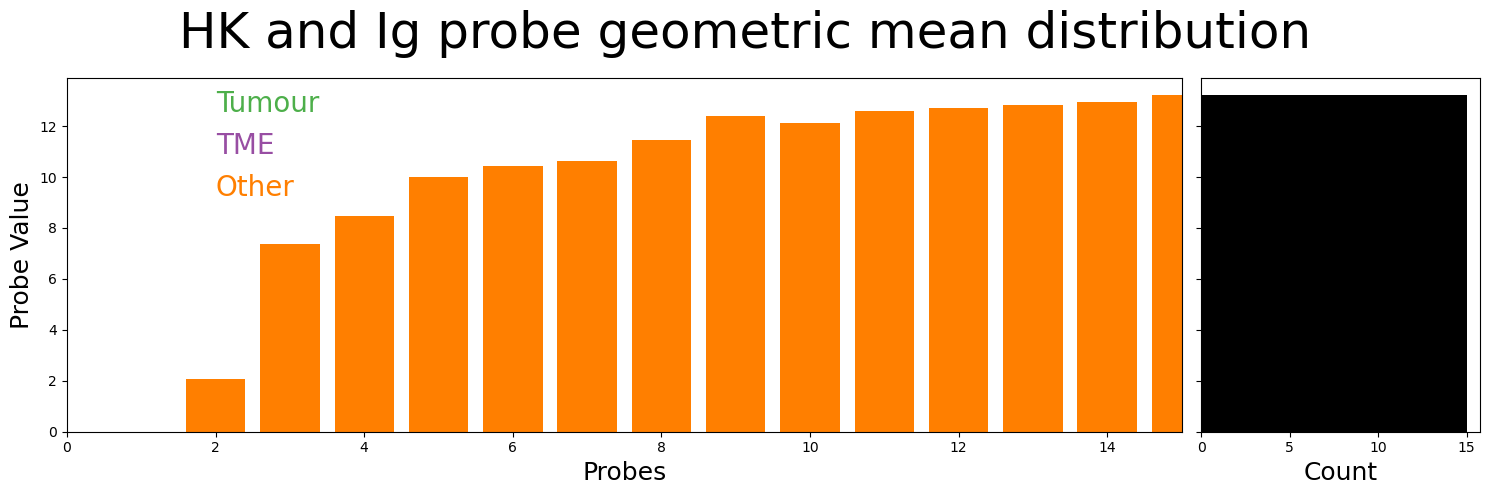

In [70]:
probe_GeoMean_Plots(HKIgCtlGeoMeans, 'HK and Ig probe geometric mean distribution')

In [71]:
HKIgCtls = masterData.HK.extend(masterData.IgCTLs)
print(f'masterData.HK :\t{masterData.HK}')


masterData.HK :	['Histone H3', 'S6', 'GAPDH', 'Ms IgG2a', 'Ms IgG1', 'Rb IgG']



Number of unique combinations: 12


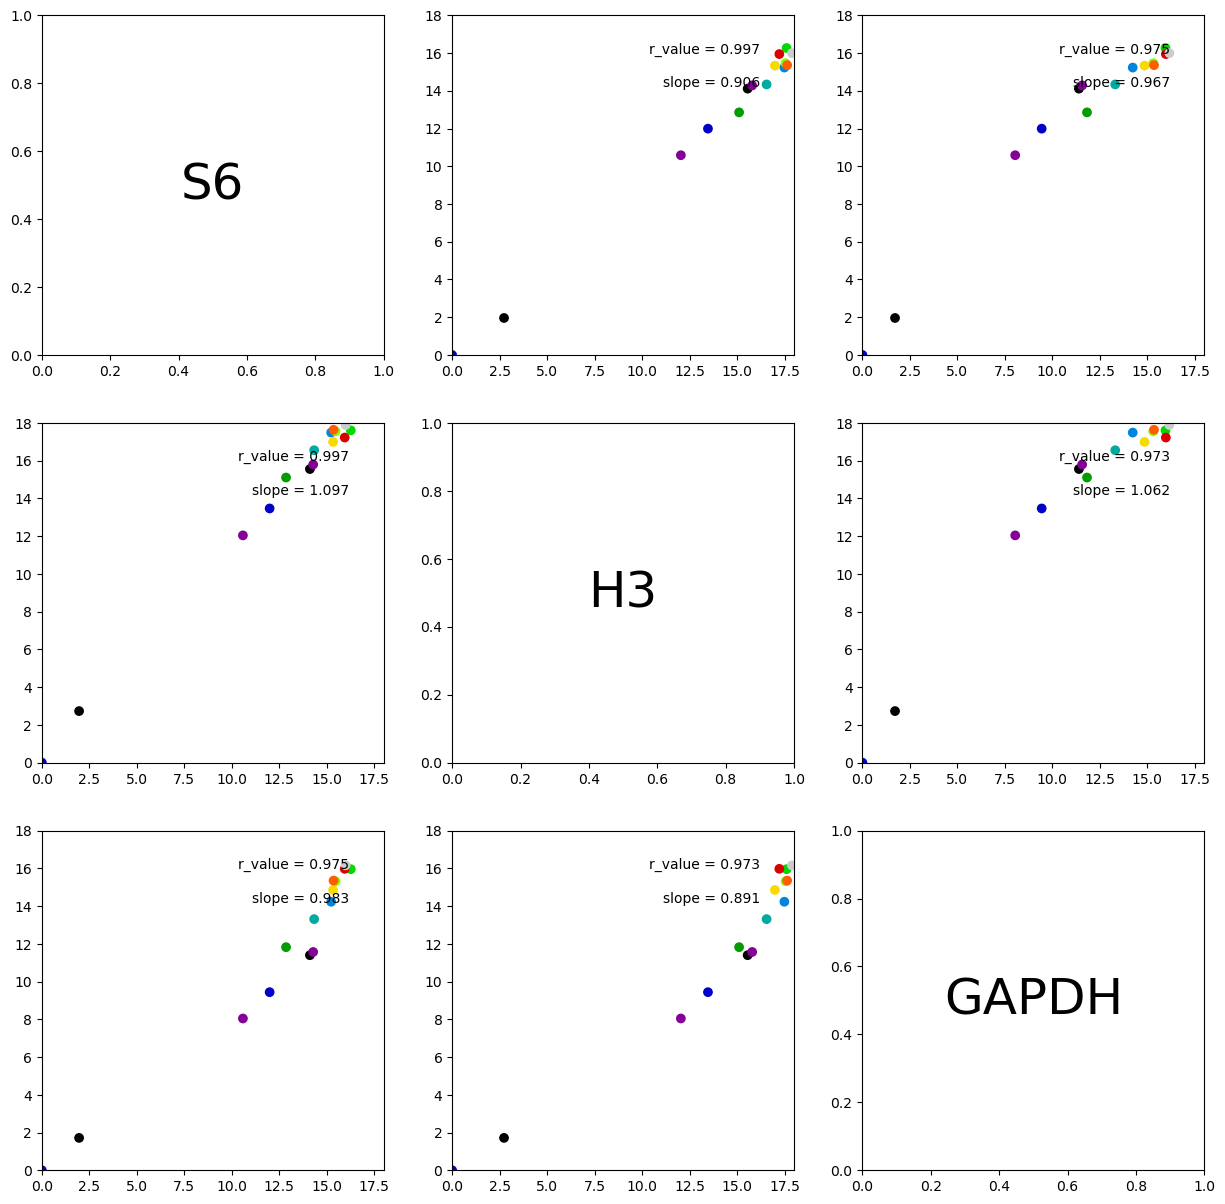

In [72]:
###
# Matrix of HK expression plots

my_cmap, colours = get_colour_mapping(sampleInfo, selectedInfo.loc['Col'])
rows = 3
cols = 3

fig, axes = plt.subplots(rows,cols, figsize=(15,15))


S6 = [(x) for x in dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['S6'].values]
H3 = [(x) for x in dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['Histone H3'].values]
GAPDH = [(x) for x in dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['GAPDH'].values]

labels = ['S6', 'H3', 'GAPDH']
dataList = [S6, H3, GAPDH]

axMin = int(min([min(x) for x in dataList]))
axMax = int(max([max(x) for x in dataList]))+1


for r in range(rows):
    for c in range(cols):
        if r==c: # This is a diagonal, insert a label
            axes[r][c].text(0.5,0.5, labels[r],ha='center', va='center', transform=axes[r][c].transAxes,fontsize=36)
        else:
            axes[r][c].scatter(dataList[c], dataList[r], color=my_cmap(colours)) #ToDo: Add a cmap, c=colours)
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dataList[c], dataList[r])
            axes[r][c].text(0.9,0.9, "r_value = " + str(r_value)[:5],ha='right', va='center', transform=axes[r][c].transAxes)
            axes[r][c].text(0.9,0.8, "slope = " + str(slope)[:5],ha='right', va='center', transform=axes[r][c].transAxes)
            axes[r][c].set_xlim(axMin,axMax)
            axes[r][c].set_ylim(axMin,axMax)



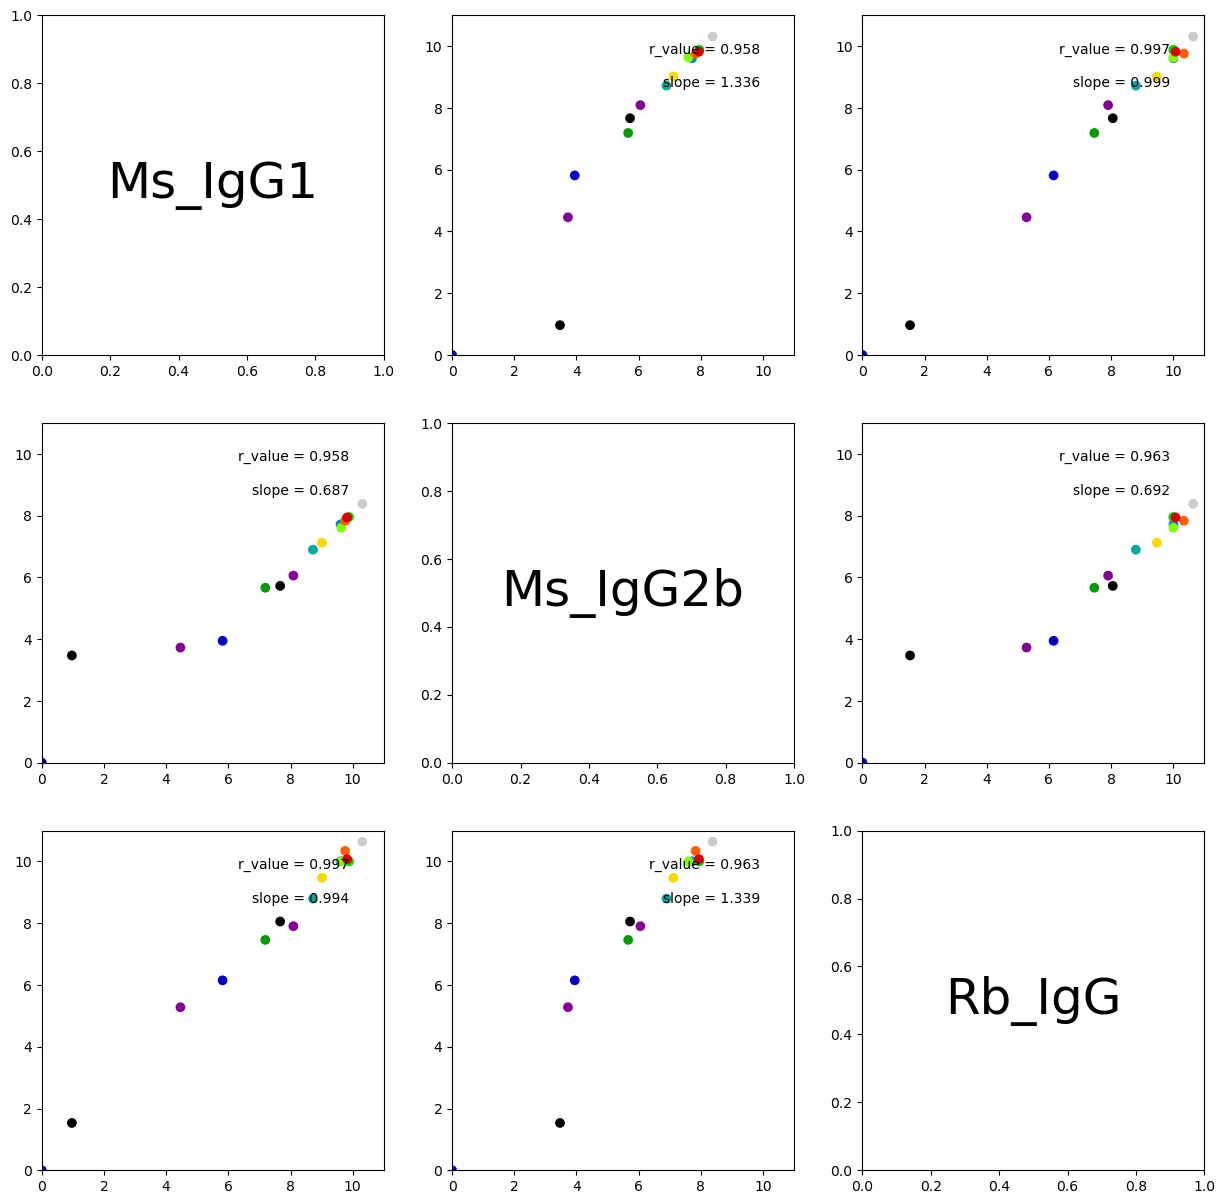

In [73]:

# Matrix of IgG expression plots
rows = 3
cols = 3

fig, axes = plt.subplots(rows,cols, figsize=(15,15))


mIG1 = [(x) for x in dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['Ms IgG1'].values]
mIG2 = [(x) for x in dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['Ms IgG2a'].values]
rIG = [(x) for x in dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['Rb IgG'].values]

labels = ['Ms_IgG1', 'Ms_IgG2b', 'Rb_IgG']
# labels = ['Rt_IgG2a', 'Rt_IgG2b', 'Rb_IgG']
dataList = [mIG1,mIG2,rIG]

axMin = int(min([min(x) for x in dataList]))
axMax = int(max([max(x) for x in dataList]))+1


for r in range(rows):
    for c in range(cols):
        if r==c: # This is a diagonal, insert a label
            axes[r][c].text(0.5,0.5, labels[r],ha='center', va='center', transform=axes[r][c].transAxes,fontsize=36)
        else:
            axes[r][c].scatter(dataList[c], dataList[r], color=my_cmap(colours)) # ToDo: Add cmap , c=colours)
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dataList[c], dataList[r])
            axes[r][c].text(0.9,0.9, "r_value = " + str(r_value)[:5],ha='right', va='center', transform=axes[r][c].transAxes)
            axes[r][c].text(0.9,0.8, "slope = " + str(slope)[:5],ha='right', va='center', transform=axes[r][c].transAxes)
            axes[r][c].set_xlim(axMin,axMax)
            axes[r][c].set_ylim(axMin,axMax)

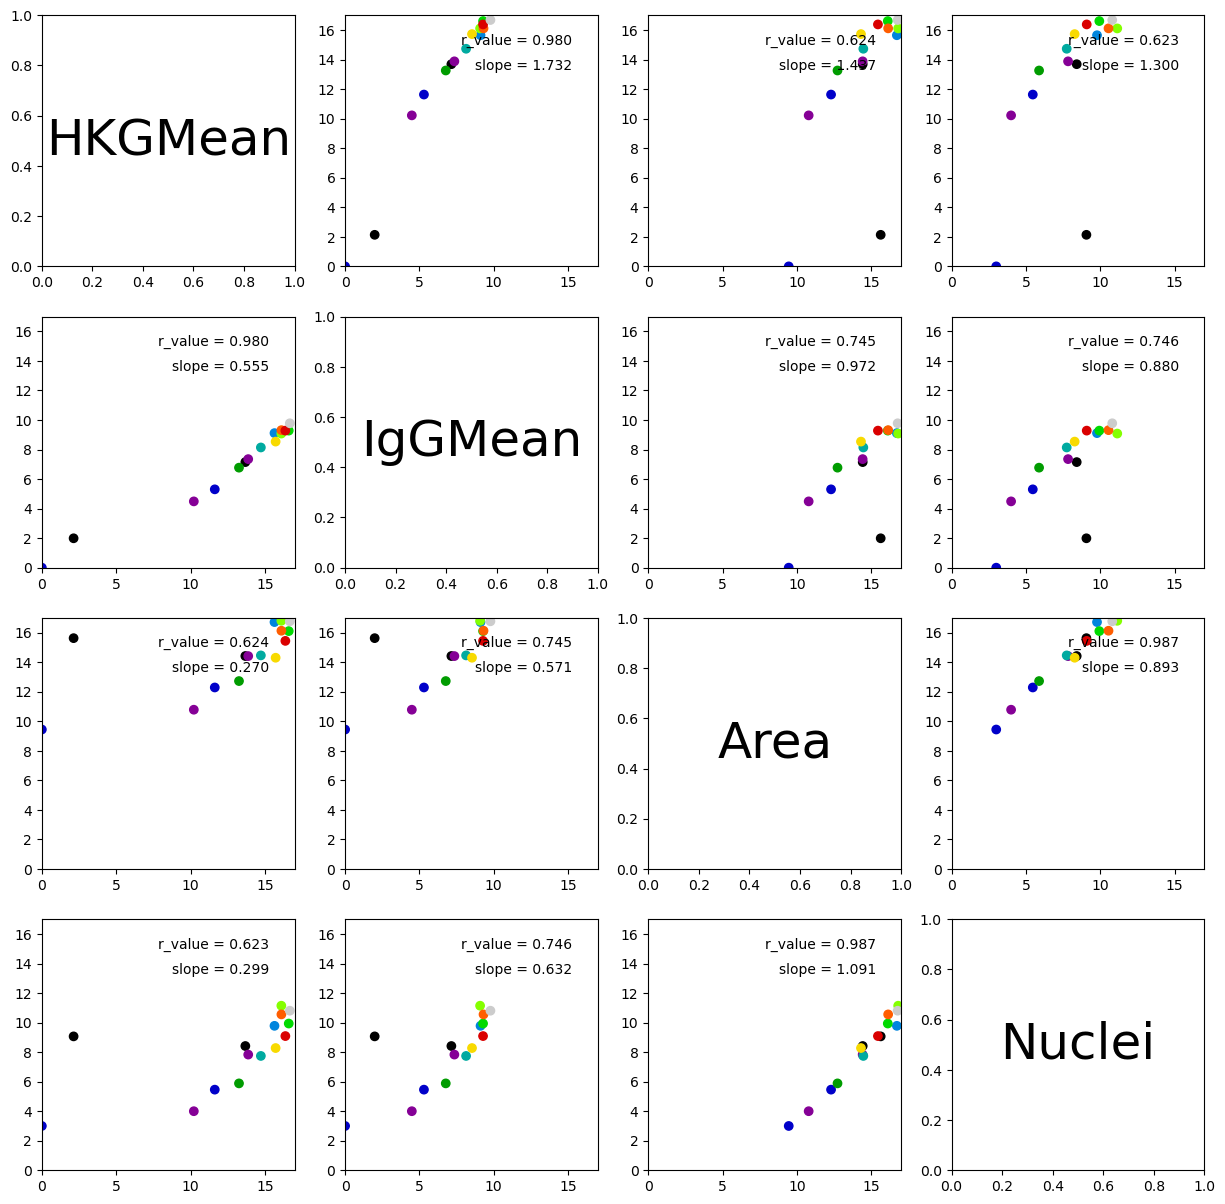

In [74]:
# Matrix of IgG expression plots
rows = 4
cols = 4

fig, axes = plt.subplots(rows,cols, figsize=(15,15))

labels = ['HKGMean', 'IgGMean', 'Area', 'Nuclei']
## Ensure HKGeoMean 
dataList = [HKGeoMean.loc[dataLog1External.columns[:-2]], 
            IgGeoMean.loc[dataLog1External.columns[:-2]], 
            np.log2(list(surfArea.values)), 
            np.log2(list(nuclei.values))]

axMin = int(min([min(x) for x in dataList]))
axMax = int(max([max(x) for x in dataList]))+1


for r in range(rows):
    for c in range(cols):
        if r==c: # This is a diagonal, insert a label
            axes[r][c].text(0.5,0.5, labels[r],ha='center', va='center', transform=axes[r][c].transAxes,fontsize=36)
        else:
            axes[r][c].scatter(dataList[c], dataList[r], color=my_cmap(colours)) # ToDo: Add cmap , c=colours)
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dataList[c], dataList[r])
            axes[r][c].text(0.9,0.9, "r_value = " + str(r_value)[:5],ha='right', va='center', transform=axes[r][c].transAxes)
            axes[r][c].text(0.9,0.8, "slope = " + str(slope)[:5],ha='right', va='center', transform=axes[r][c].transAxes)
            axes[r][c].set_xlim(axMin,axMax)
            axes[r][c].set_ylim(axMin,axMax)
                
            

# <span style="color:green"> Load-in default QC data from DSP analysis suite for further data QC </sapan>
<div class="alert alert-block alert-success">
load in QC data from DSP analysis suite.
</div>

In [75]:
QCmasterData = MasterData(os.path.join(configDict['rootDir'],configDict['QCDataPath']))
QCdataExternal, QCdataLog1External, QCsampleInfo = QCmasterData.get_data()

print(QCmasterData.probeClass)
print(QCmasterData.probeClassDict)

if (type(dropSamples) == pd.core.indexes.base.Index):
    QCdataLog1External, QCsampleInfo = QCmasterData.drop_AOIs(list(dropSamples), writeOrig=True)
    print(QCdataLog1External.shape)
    print(QCsampleInfo.shape)

QCdataLog1External, QCsampleInfo = QCmasterData.add_class_mean(QCmasterData.dataLog1)


CD45                    Endogenous
PD-L1                   Endogenous
Ms IgG2a                  Negative
Ki-67                   Endogenous
Beta-2-microglobulin    Endogenous
CD4                     Endogenous
PD-1                    Endogenous
GZMB                    Endogenous
SMA                     Endogenous
CD56                    Endogenous
Histone H3                 Control
CD8                     Endogenous
CTLA4                   Endogenous
CD68                    Endogenous
Ms IgG1                   Negative
CD11c                   Endogenous
PanCk                   Endogenous
HLA-DR                  Endogenous
Fibronectin             Endogenous
S6                         Control
CD3                     Endogenous
Rb IgG                    Negative
GAPDH                      Control
CD20                    Endogenous
Name: ProbeClass, dtype: object
{'Positive': 'A', 'Negative': 'B', 'Control': 'C', 'Endogenous': 'E'}
Positive Control count:	0, []
Nagative Control count:	3, [

/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [76]:
# View log transformed QC data

QCdataLog1External

,Protein_Training_Scan_2_001_PanCK,Protein_Training_Scan_2_001_PanCK_,Protein_Training_Scan_2_002_PanCK,Protein_Training_Scan_2_002_PanCK_,Protein_Training_Scan_2_003_PanCK,Protein_Training_Scan_2_003_PanCK_,Protein_Training_Scan_2_004_PanCK_,Protein_Training_Scan_2_005_PanCK_,Protein_Training_Scan_2_006_PanCK_,Protein_Training_Scan_2_007_PanCK,Protein_Training_Scan_2_007_PanCK_,Protein_Training_Scan_2_008_PanCK,Protein_Training_Scan_2_008_PanCK_,Protein_Training_Scan_2_009_PanCK,Protein_Training_Scan_2_009_PanCK_,mean,probeClass
CD45,10.075203,12.180666,7.182381,8.786419,11.994607,7.313632,14.381890,12.436389,10.755476,15.000984,16.165607,13.013742,15.606536,14.157680,16.511700,12.370862,E
PD-L1,5.785276,12.180666,2.576998,4.563330,11.994607,2.710311,7.361612,5.295310,4.063559,9.806244,8.721376,6.802384,8.338687,8.762270,8.929391,7.192801,E
Ms IgG2a,6.252248,15.513627,4.282812,5.156266,11.994607,3.510059,8.076919,5.922958,4.773808,8.235332,8.835707,6.261586,8.630139,7.373079,9.116147,7.595687,B
Ki-67,16.159159,12.178739,12.691998,14.888233,11.994607,13.362289,17.704912,15.730876,14.092475,12.256443,12.834310,10.818932,13.462100,11.200363,12.723463,13.473258,E
Beta-2-microglobulin,9.172236,12.074945,5.835054,8.087030,11.994607,6.372222,11.090982,8.636236,7.319903,11.875063,12.494932,9.637057,11.886343,10.881456,12.731898,10.005998,E
CD4,9.165823,12.180666,5.445437,7.899223,11.994607,6.251856,13.193547,10.995466,9.556659,11.867688,12.650467,9.820441,11.962255,11.318095,13.646277,10.529901,E
PD-1,8.100410,13.138361,4.611478,6.890809,11.994607,5.253789,9.769452,7.547177,6.212848,9.815681,10.655417,8.022990,10.234879,8.727962,10.660718,8.775772,E
GZMB,9.827993,12.289754,6.943075,8.697966,11.994607,6.963309,11.413691,9.682916,7.852092,10.928684,11.857437,9.090626,11.463121,9.937140,11.945944,10.059222,E
SMA,11.343342,12.180666,8.284585,10.061150,11.994607,7.963391,11.102788,8.870890,7.461927,12.926878,14.124228,10.745585,13.375306,12.360900,15.099234,11.193032,E
CD56,11.344853,13.197073,8.192307,10.136258,11.994607,8.315679,11.906199,9.631049,8.210404,11.665370,12.317460,9.709475,12.092970,10.663634,12.488589,10.791061,E


## <span style="color:green"> Visualise QC OR ERCC data before normalisation </sapan>
<div class="alert alert-block alert-success">
Check for obvious outliers etc.
</div>

In [77]:
# Sort data by probeclass then mean for nicer visualisation on plots
QCdataSortedERCC = QCdataLog1External.sort_values(by = ['probeClass', 'mean'], ascending=[True,True])



Number of unique combinations: 12

Number of unique combinations: 2

Number of unique combinations: 2


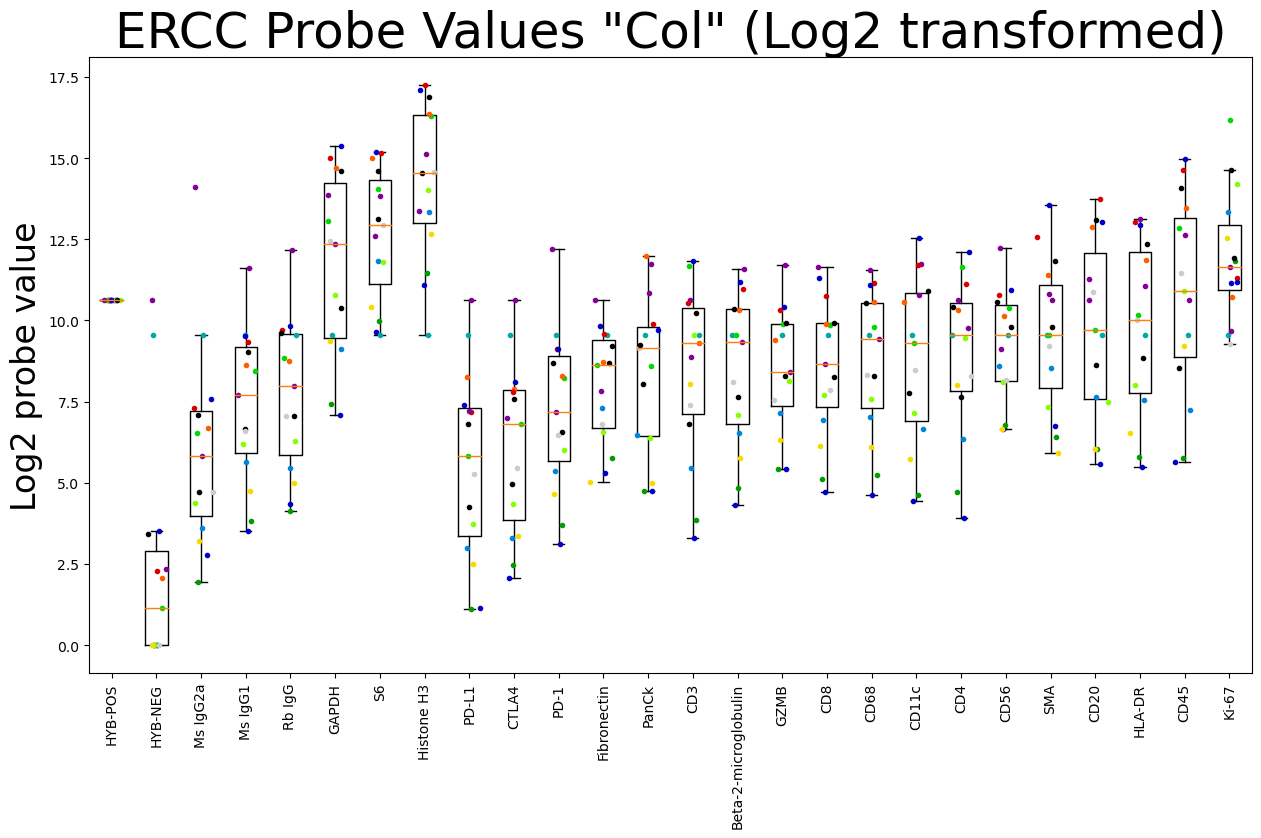

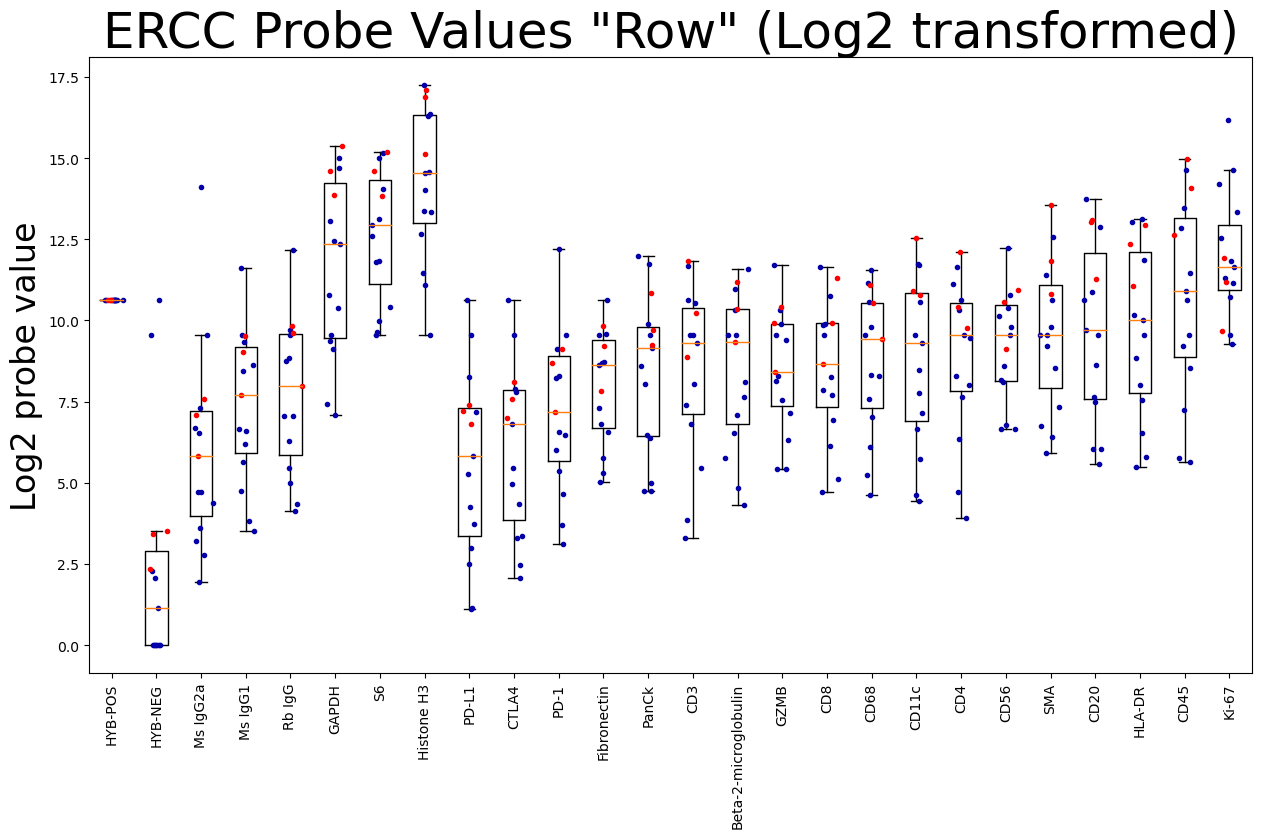

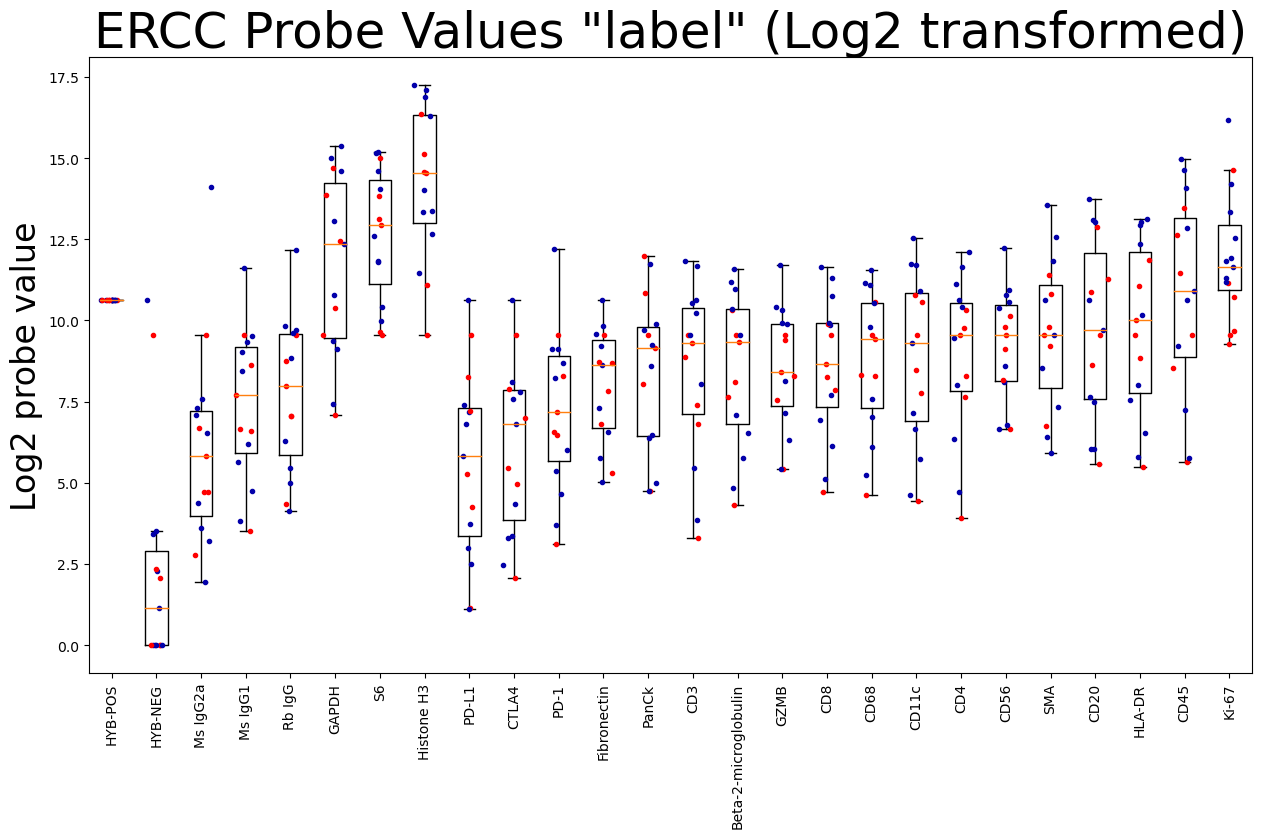

In [78]:
for s in configDict['selectedData']:
    draw_probe_plot(erccDataSorted, sampleInfo, selectedInfo, s, 'ERCC Probe Values \"' + s + '\"')
    


Number of unique combinations: 12

Number of unique combinations: 2

Number of unique combinations: 2


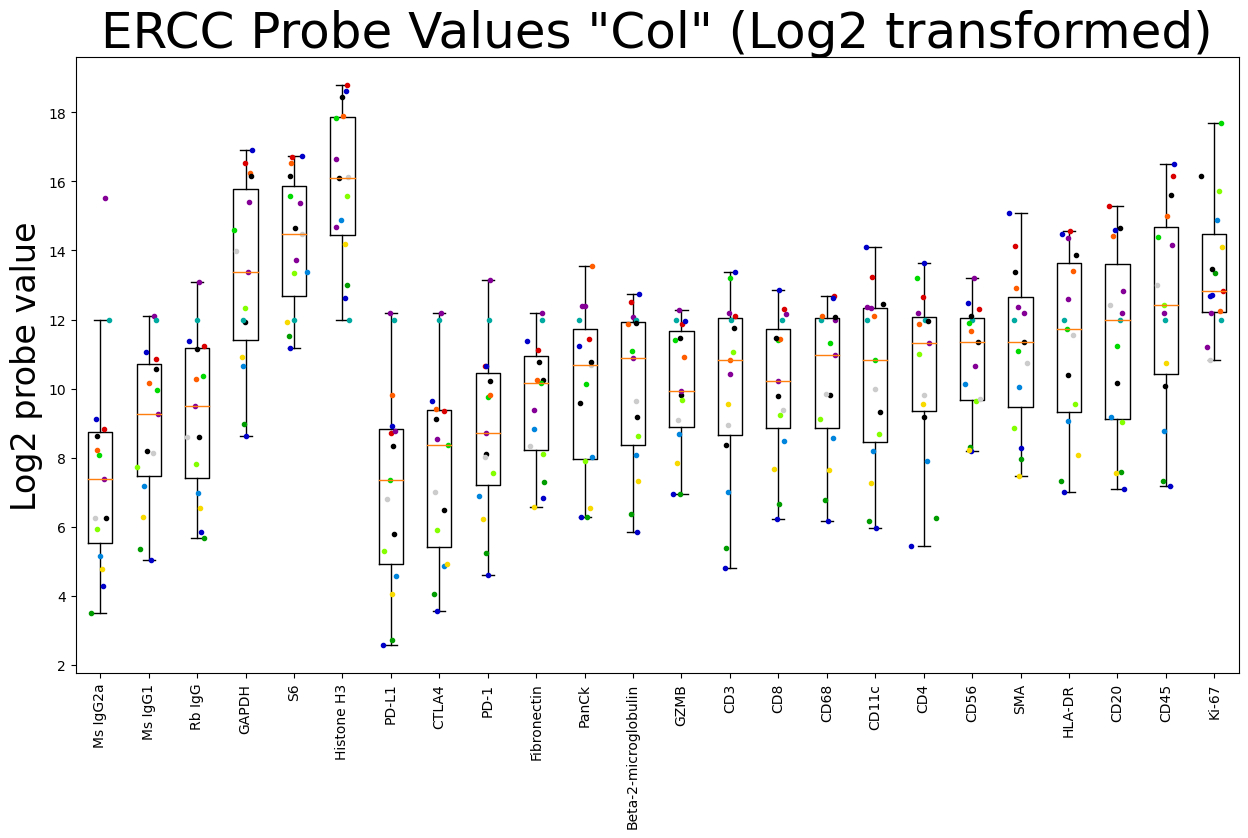

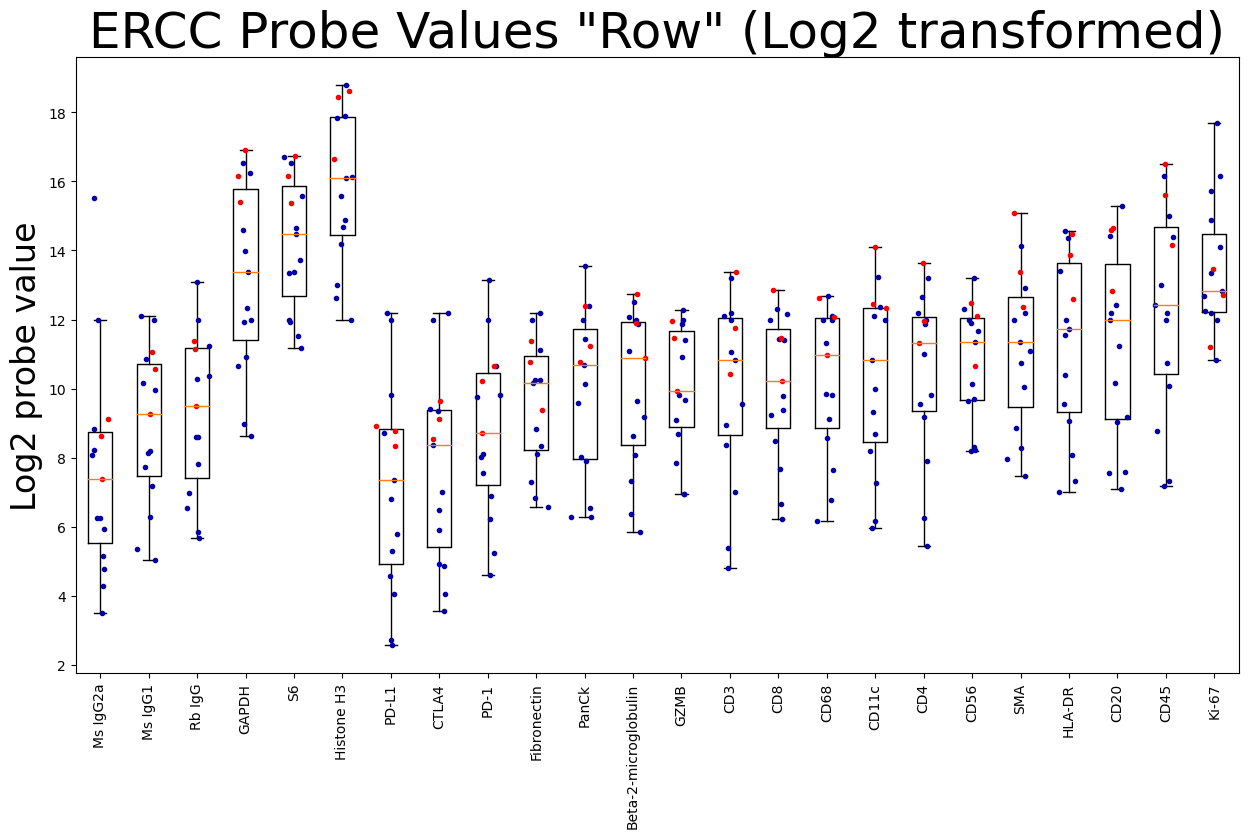

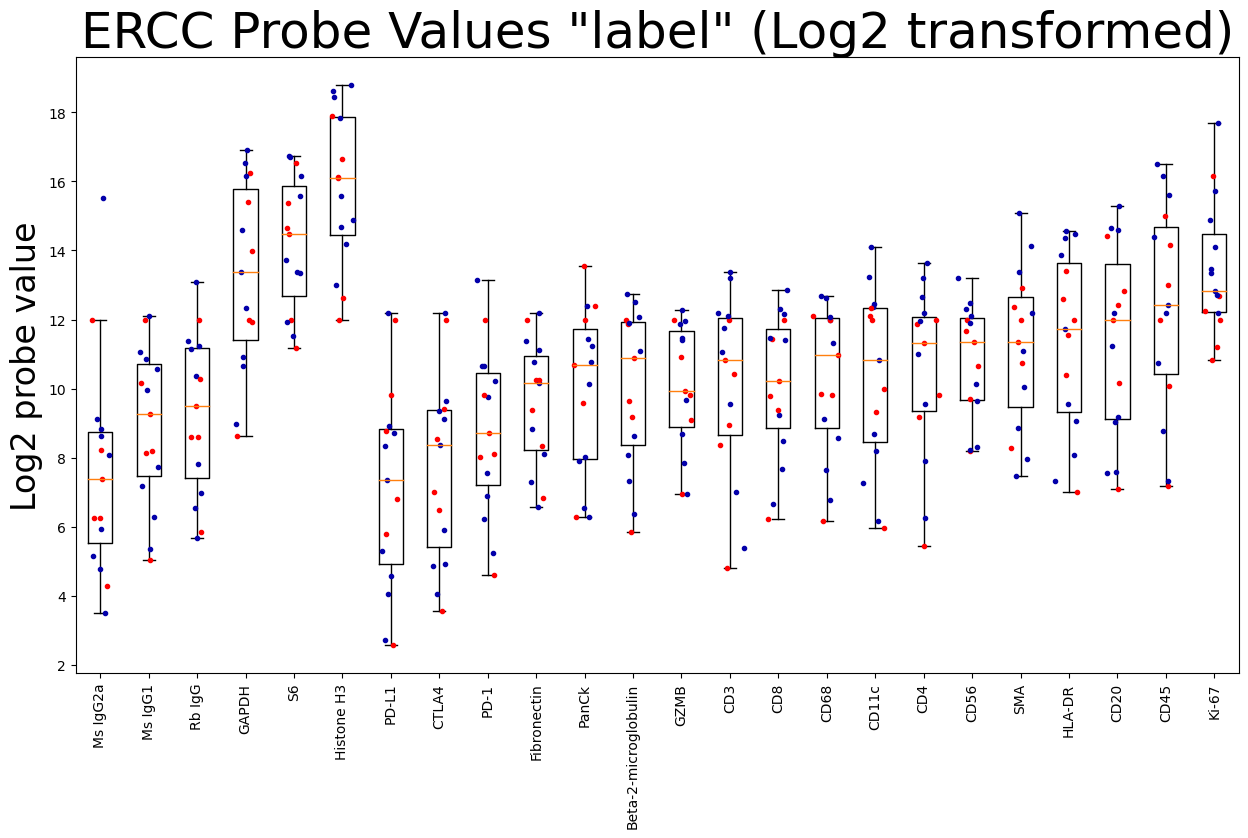

In [79]:
for s in configDict['selectedData']:
    draw_probe_plot(QCdataSortedERCC, sampleInfo, selectedInfo, s, 'ERCC Probe Values \"' + s + '\"')
    

In [80]:
QCSortedIndex = sorted(masterData.probeClass.index, key=lambda x: masterData.probeClassDict[masterData.probeClass[x]])
# QCSortedIndex
QCSortedProbes = masterData.probeClass[QCSortedIndex]
QCSortedProbes.name = "Code.Class"
QCSortedProbes

# list(QCSortedProbes.index)


HYB-POS                   Positive
Ms IgG2a                  Negative
Ms IgG1                   Negative
Rb IgG                    Negative
HYB-NEG                   Negative
Histone H3                 Control
S6                         Control
GAPDH                      Control
CD45                    Endogenous
PD-L1                   Endogenous
Ki-67                   Endogenous
Beta-2-microglobulin    Endogenous
CD4                     Endogenous
PD-1                    Endogenous
GZMB                    Endogenous
SMA                     Endogenous
CD56                    Endogenous
CD8                     Endogenous
CTLA4                   Endogenous
CD68                    Endogenous
CD11c                   Endogenous
PanCk                   Endogenous
HLA-DR                  Endogenous
Fibronectin             Endogenous
CD3                     Endogenous
CD20                    Endogenous
Name: Code.Class, dtype: object

In [81]:
erccData

,Protein_Training_Scan_2_001_PanCK,Protein_Training_Scan_2_001_PanCK_,Protein_Training_Scan_2_002_PanCK,Protein_Training_Scan_2_002_PanCK_,Protein_Training_Scan_2_003_PanCK,Protein_Training_Scan_2_003_PanCK_,Protein_Training_Scan_2_004_PanCK_,Protein_Training_Scan_2_005_PanCK_,Protein_Training_Scan_2_006_PanCK_,Protein_Training_Scan_2_007_PanCK,Protein_Training_Scan_2_007_PanCK_,Protein_Training_Scan_2_008_PanCK,Protein_Training_Scan_2_008_PanCK_,Protein_Training_Scan_2_009_PanCK,Protein_Training_Scan_2_009_PanCK_,mean,probeClass
CD45,8.536453,10.641454,5.648055,7.245813,9.545404,5.771981,12.842609,10.897202,9.216017,13.461714,14.626000,11.474592,14.067115,12.618543,14.972290,10.771016,E
PD-L1,4.257682,10.641454,1.155674,2.995238,9.545404,1.108521,5.824802,3.737966,2.483411,8.267314,7.186364,5.257456,6.802544,7.222073,7.391953,5.591857,E
Ms IgG2a,4.721412,14.111174,2.780666,3.598022,9.545404,1.935269,6.539135,4.372090,3.209772,6.697089,7.300343,4.713986,7.093393,5.831123,7.578468,6.001823,B
Ki-67,14.619815,11.640491,11.152739,13.349145,9.545404,11.823125,16.165615,14.191805,12.553370,10.717228,11.294944,9.279498,11.922752,9.661053,11.184186,11.940078,E
Beta-2-microglobulin,7.634011,11.589550,4.308485,6.545464,9.545404,4.828243,9.551869,7.095384,5.776591,10.335866,10.955637,8.097166,10.347183,9.342096,11.192620,8.476371,E
HYB-POS,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,10.641454,A
CD4,7.627604,10.641454,3.922813,6.357308,9.545404,4.707454,11.654290,9.456058,8.016692,10.328492,11.111137,8.280648,10.423081,9.778799,12.106933,8.930544,E
PD-1,6.563427,12.198450,3.101826,5.346007,9.545404,3.704106,8.230621,6.004298,4.664622,8.276748,9.116995,6.481408,8.696323,7.187739,9.121894,7.215991,E
GZMB,8.289356,11.697041,5.409658,7.157262,9.545404,5.420963,9.874540,8.142988,6.310091,9.389565,10.318330,7.550357,9.924058,8.397549,10.406769,8.522262,E
SMA,9.804239,10.641454,6.747567,8.521448,9.545404,6.422656,9.563674,7.330306,5.919014,11.387639,12.584705,9.206134,11.835964,10.821700,13.559840,9.592784,E


# <span style="color:green"> Export data fopr further analysis </sapan>
<div class="alert alert-block alert-success">
Text descriuption here
</div>

# <span style="color:orange"> Export ERCC corrected data </span>

<div class="alert alert-block alert-warning">
Choose whether to output manually ERCC corrected data or ERCC corrected data from DSP QC output
</div>

In [82]:
ERCCType = 'manual'
# ERCCType = 'DSP_QC'


if (ERCCType == 'manual'):
    # Export manually ERCC corrected data for further analysis
    print('manual ERCC data export')
    QCExport = erccData.sort_values(by = ['probeClass', 'mean'], ascending=[True,False])
    probeOrder = QCExport.index
    QCExport = QCExport.drop(labels=['mean','probeClass'], axis=1)
    QCExport
elif (ERCCType == 'DSP_QC'):
    # Export Nanostring QC'd ERCC corrected data for further analysis
    print('DSP QC ERCC data export')
    QCExport = QCmasterData.dataOrig.copy()
    posNeg = masterData.dataOrig.loc[['HYB-NEG','HYB-POS'],]
    QCExport = pd.concat([QCExport,posNeg])
    QCExport = QCExport.loc[QCSortedIndex,]
    QCExport = pd.concat([QCSortedProbes, QCExport], axis = 1)
    QCExport.index.name = 'Name'
    QCExport
else:
    print('ERCC correction type not valid, exiting.')
    # break


manual ERCC data export


In [83]:
# Reverse log2 transformation before normalisation
QCExport = pow(2, QCExport)

QCExport = pd.concat([QCSortedProbes, QCExport], axis = 1)
QCExport = QCExport.loc[list(probeOrder)]
QCExport.index.name = 'Name'
QCExport


,Code.Class,Protein_Training_Scan_2_001_PanCK,Protein_Training_Scan_2_001_PanCK_,Protein_Training_Scan_2_002_PanCK,Protein_Training_Scan_2_002_PanCK_,Protein_Training_Scan_2_003_PanCK,Protein_Training_Scan_2_003_PanCK_,Protein_Training_Scan_2_004_PanCK_,Protein_Training_Scan_2_005_PanCK_,Protein_Training_Scan_2_006_PanCK_,Protein_Training_Scan_2_007_PanCK,Protein_Training_Scan_2_007_PanCK_,Protein_Training_Scan_2_008_PanCK,Protein_Training_Scan_2_008_PanCK_,Protein_Training_Scan_2_009_PanCK,Protein_Training_Scan_2_009_PanCK_
Name,,,,,,,,,,,,,,,,
HYB-POS,Positive,1597.337769,1597.337769,1597.337769,1597.337769,1597.337769,1597.337769,1597.337769,1597.337769,1597.337769,1597.337769,1597.337769,1597.337769,1597.337769,1597.337769,1597.337769
Rb IgG,Negative,132.797256,4620.379883,20.166430,43.596310,747.227844,17.640547,454.053741,77.359528,32.145325,428.514252,829.897156,133.977631,777.663696,249.831451,916.772400
Ms IgG1,Negative,101.439613,3120.505371,11.408383,49.659832,747.227844,13.985118,344.641388,73.476509,26.646210,395.497406,643.245850,97.438660,518.391968,209.640121,730.161438
Ms IgG2a,Negative,26.380714,17696.464844,6.871695,12.109115,747.227844,3.824495,92.998466,20.707626,9.252041,103.758713,157.623962,26.245285,136.560165,56.930225,191.137665
HYB-NEG,Negative,1.000000,1597.337769,1.000000,1.000000,747.227844,1.000000,2.209059,1.000000,1.000000,4.185022,4.858554,1.000000,10.782157,5.097614,11.493346
Histone H3,Control,24066.791016,10609.477539,2187.587891,10355.366211,747.227844,2814.369873,81300.148438,16733.136719,6442.113770,83508.757812,156003.484375,24604.371094,122068.484375,35502.828125,139475.203125
S6,Control,8842.999023,6218.217773,797.368591,3633.181641,747.227844,1011.669922,16979.148438,3596.661865,1353.381958,32957.253906,36573.019531,7781.320801,25141.408203,14615.878906,37516.488281
GAPDH,Control,1346.008789,5246.625000,136.894348,552.335754,747.227844,172.181107,8485.164062,1764.541992,661.325134,26578.433594,32928.597656,5573.166504,25011.333984,14900.689453,41995.839844
Ki-67,Endogenous,25176.931641,3192.543457,2276.715820,10435.013672,747.227844,3623.391357,73508.070312,18713.669922,6010.917480,1683.476562,2512.562500,621.451538,3882.451904,809.592834,2326.887939


In [84]:
# check if normalisation directory exists and create it if not

normDir = os.path.join(configDict['rootDir'], 'Normalisation')
if not (os.path.isdir(normDir)):
    os.mkdir(normDir)

print(normDir)


./Normalisation


In [85]:
# Write normalised data to file with _preNorm suffix

project = configDict['projectName']
qcCSV = 'QC_' + project + '_preNorm.csv'

# writeOutput= False
writeOutput = True
if writeOutput:
    QCExport.to_csv(os.path.join(normDir, qcCSV))
# writeOutput= False


# <span style="color:green"> Run NanoString Normalisation script in R </sapan>
<div class="alert alert-block alert-success">
Text descriuption here
</div>

In [86]:
cmd = 'Rscript ../DSP_EDA_Protein/NSNorm.R -d ' + normDir + ' -f ' + qcCSV
print(cmd)
os.system(cmd)


Rscript ../DSP_EDA_Protein/NSNorm.R -d ./Normalisation -f QC_example_preNorm.csv
[[1]]
[1] FALSE

[[2]]
[1] FALSE

[[3]]
[1] FALSE

[[4]]
[1] FALSE

[[5]]
[1] FALSE

[[6]]
[1] FALSE

[[7]]
[1] FALSE

[[8]]
[1] FALSE

[[9]]
[1] FALSE

[[10]]
[1] FALSE

[[11]]
[1] FALSE

[[12]]
[1] FALSE

[[13]]
[1] FALSE



Loading required package: matrixStats
Loading required package: ruv
Loading required package: NanoStringNorm
Loading required package: data.table
Loading required package: NormqPCR
Loading required package: optparse
Loading required package: ComplexHeatmap
Loading required package: dplyr
Loading required package: plotrix
Loading required package: tuple
Loading required package: scales
Loading required package: ggplot2
Loading required package: stringr
There were 13 warnings (use warnings() to see them)
Error in make_option(c("-d", "--datadir"), type = "character", default = NULL,  : 
  could not find function "make_option"
Execution halted


256

### ToDo: Collate figures into a pdf